# 1. Preamble
Import modules, define functions that may or may not end up getting used, etc...

In [2]:
%matplotlib qt

# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn
import random

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make a new colormap interpolating between red and blue to encode MA fraction
n_points=501
comp_colors = []
for i in range(n_points):
    # append RGBA tuple
    comp_colors.append((i/n_points,0,1-i/n_points,1))
MA_cmp = ListedColormap(comp_colors)


#change default plot settings
'''default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)'''

mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:

# function to correlate variables, calculate Pearson r, and plot results
def pearson_correlation(x,y,x_lab,y_lab):
    plt.figure()
    plt.plot(x,y,'.')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    #infinites = np.logical_or(np.isfinite(x), np.isfinite(y))
    #invalids = np.logical_or(nas,infinites)
    z = scipy.stats.pearsonr(x[~nas],y[~nas])
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),1.2*np.max(y))
    plt.text(0.5*(np.min(x)+np.max(x)),1.1*np.max(y),np.round(z,decimals=3))
    #print(np.round(z,decimals=3))

def bleach_rate_from_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # if the loop gets to the end without crossing the threshold, assign NaN value to the bleaching rate
    if kk == len(Tr)-1:
        tau = np.nan
    else:
    # do linear interpolation between points just above and just below threshold to get 
    # "failure" time at exactly the threshold
        tau = t[kk-1] + (t[kk]-t[kk-1])*(threshold-Tr[kk-1])/(Tr[kk]-Tr[kk-1])
    
    # invert "failure time" to get bleaching rate, in 1/min
    bleach_rate = (threshold-1)/tau
    
    # return the bleaching rate
    return bleach_rate

# alternative way to extract bleaching rate: instead of taking secant approximation to degradation rate, 
# perform a linear fit to all the data up to the threshold and ignore everything else;
# if the threshold can't be reached, just fit the entire dataset
def bleach_rate_from_linear_fit_to_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # use linear polynomial fit up to threshold
    coeffs = np.polyfit(t[:kk+1],Tr_norm[:kk+1],1)
    bleach_rate = coeffs[0]
    intercept = coeffs[1]
    
    # return the bleaching rate
    return bleach_rate, intercept

# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
    if temp <= 15:
        m_color = np.array([0.00,0.00,0.20])
    elif 15 < temp <= 35:
        m_color = np.array([0.00,0.20,0.20])
    elif 35 < temp <= 55:
        m_color = np.array([0.00,0.20,0.00])
    elif 55 < temp <= 75:
        m_color = np.array([0.20,0.20,0.00])
    elif 75 < temp:
        m_color = np.array([0.20,0.00,0.00])

    # humidity encoded by brightness
    if rh < 10:
        m_color *= 1
    elif 10 < rh < 30:
        m_color *= 2
    elif 30 < rh < 50:
        m_color *= 3
    elif 50 < rh < 70:
        m_color *= 4
    elif 70 < rh:
        m_color *= 5

    # illumination encoded by marker shape
    if illum == 8:
        m_shape = 'o'
    elif illum == 32:
        m_shape = 'D'
    elif illum == 1:
        m_shape = 'v'
    elif illum == 16:
        m_shape = 's'
    elif illum == 0:
        m_shape = 'p'
    elif illum == 4:
        m_shape = 'h'
    elif illum == 0.5:
        m_shape = '^'

    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 50:
        m_fill = 'right'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

def plot_residuals(resids):
    plt.figure()
    _, bins, _ = plt.hist(resids)
    resid_mean = np.mean(resids)
    resid_sd = np.std(resids)
    resid_x=np.linspace(np.min(resids),np.max(resids),num=100)
    norm_dist = np.exp(-0.5*((resid_x-resid_mean)/resid_sd)**2)/(resid_sd*np.sqrt(2*np.pi))
    scale = len(resids)*(bins[1]-bins[0])
    plt.plot(resid_x,norm_dist*scale)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')    
            
# interpolate early time features to a universal time range (default is 10 min)
def interp_early_time(time_raw,timeseries,univ_horiz=10):

    idx = np.abs(time_raw-univ_horiz).idxmin() # index of datapoint closest to the horizon
    # if the nth index is at or below the horizon, increment by one;
    # otherwise, leave as is so as not to include predictions outside
    if time_raw[idx] >= univ_horiz:
        idx += 1
    else:
        idx += 2
    # interpolate from range of allowed indices to prediction horizon (5 points after start)
    series_interp_func = sp.interpolate.interp1d(time_raw[:idx],timeseries[:idx])
    t = np.linspace(0,univ_horiz,num=6)
    series_interp = series_interp_func(t)

    return(series_interp[-5:])

# 2. Import Data/Calculate Physics-Inspired Features

In this block, read in the data, which has already been boiled down into features by a separate "featurizer" notebook that is somewhat time-consuming to run. From the raw environment and composition data in the featurized dataset, calculate physics-inspired features. 

C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


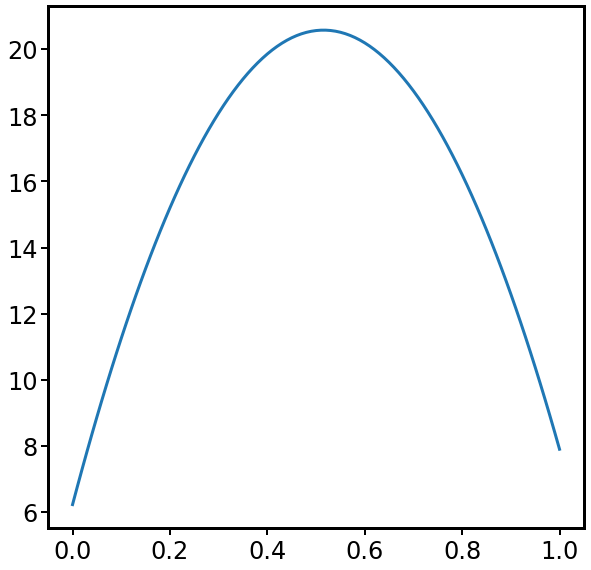

In [3]:
# Read the CSV containing featurized data into the "rawdata_df" DataFrame
#readpath = 'C:/Users/Wiley Dunlap-Shohl/Desktop/Just in Case/Calculations/hp-db/hp-db/Ld/'
readpath = 'C:/Users/Wiley.LAPTOP-KQ1TRN8R/Desktop/Just In Case/Calculations/hp-db/hp-db/Ld/'
readname = '201124_Featurized_Data.csv'
rawdata_df = pd.read_csv(readpath+readname)

# Convert RH and %O2 to more partial pressures
T_gas = 25 # temperature of gas above the sample, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
rawdata_df['P_H2O'] = 101325*rawdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
rawdata_df['P_O2'] = 101325*rawdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa]

# Add physics-inspired features

# adsorption energy for O2, eV
E_ads_O2_MAPI = -0.19
E_ads_O2_FACs = -0.10
E_ads_O2 = (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

# adsorption energy for H2O, eV
E_ads_MAPI = -0.45
E_ads_FAPI = -0.27 
E_ads_H2O = (E_ads_FAPI+(E_ads_MAPI-E_ads_FAPI)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

T_Kelvin = rawdata_df['Temp (deg C)'] + 273.15 # convert temperature to K
h = 6.626e-34 # Planck's constant, J s
h_bar = h/(2*np.pi)
kB = 1.38e-23 # Boltzmann's constant, J/K

# calculate Langmuir isotherm for O2, using Keq following derivation in Schroeder
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*rawdata_df['P_O2']/(1+Keq_O2*rawdata_df['P_O2'])     

# calculate Langmuir isotherm for H2O using empirical internal partition function...

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*rawdata_df['P_H2O']/(1 + Keq_H2O*rawdata_df['P_H2O'])

# activation energy for the photooxidation pathway, determined from a parabolic fit to the following:
# Ea(x_MA = 0) = 0.49 eV; Ea(x_MA = 0.5) = 0.9 eV; Ea(x_MA = 1) = 0.5 eV
x_meas = np.array([0,0.5,1]) # mole fraction
Ea_meas = np.array([0.49,0.9,0.5]) # activation energies, eV, from Arrhenius fits
Ea_fit = np.polyfit(x_meas,Ea_meas,2) # fit a parabola
x_fit = np.linspace(0,1,num=101)
#plt.plot(x_fit,Ea_fit[0]*x_fit**2 + Ea_fit[1]*x_fit + Ea_fit[2])
rawdata_df['Ea_O2 (eV)'] = Ea_fit[0]*rawdata_df['MA fraction']**2 + Ea_fit[1]*rawdata_df['MA fraction'] + Ea_fit[2]

# rate constant for photooxidation, determined from a parabolic fit to the rate constants at 85C
ln_R0 = np.log(np.array([506.82, 8.5274e8, 2703.2]))
#ln_R0 = np.array([-9.65, -8.6, 2703.2])
R0_fit = np.polyfit(x_meas,ln_R0,2) # fit a parabola
plt.plot(x_fit,R0_fit[0]*x_fit**2 + R0_fit[1]*x_fit + R0_fit[2])
PhOx_RC  = np.exp(R0_fit[0]*rawdata_df['MA fraction']**2 + R0_fit[1]*rawdata_df['MA fraction'] + R0_fit[2])


# assign calculated activation energy to DataFrame

# calculate electron concentration
me = 9.11e-31 # electron mass, kg
mc = 0.1*me # electron effective mass, kg
mv = 0.1*me # hole effective mass, kg
# CB and VB effective densities of states, 1/m3
Nc = 2*((mc*kB*(rawdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Nv = 2*((mv*kB*(rawdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Eg = 1.6 # perovskite band gap, eV
# intrinsic carrier density, 1/m3
ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*(rawdata_df['Temp (deg C)'].values+273.15))))
# excited carrier concentration, 1/m3
n_exc = ni*np.sqrt(np.exp(rawdata_df['QFLS_0'].values/(8.617e-5*(rawdata_df['Temp (deg C)'].values+273.15))))


# assign photooxidation and hydration rates to DataFrame

# non-dimensional photo-oxidation rate (Langmuir term * Arrhenius term)
gamma = 0.7
#rawdata_df['PhotoOx_rate'] = LAI_O2*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['PhotoOx_rate'] = LAI_O2*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['PhotoOx_rate_P'] = rawdata_df['P_O2']*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = PhOx_RC*rawdata_df['P_O2']*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = rawdata_df['P_O2']*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['LAI_O2'] = LAI_O2
rawdata_df['Ox_rate_LAI'] = LAI_O2*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['Ox_rate_P'] = rawdata_df['P_O2']*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['Arrhenius_Ox'] = np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
# non-dimensional hydration rate Langmuir term * MA_fraction
rawdata_df['Hydration_rate'] = LAI_H2O
# Entropy of Mixing calculation:
 
xMA=rawdata_df['MA fraction']           #MA mole fraction
xFA=0.83*(1-rawdata_df['MA fraction'])  #FA mole fraction along the composition line we've been studying as 10/5/20 MUST CHANGE FOR MORE DIVERSE COMP SET
xCs=1-xMA-xFA                           #Cs mole fraction MUST CHANGE IF QUAD CATION COMPOSITIONS CONSIDERED

rawdata_df['delS_mix'] = 0 # initalization step

for ii in range(len(xMA)):
    if xMA[ii]==1:
        rawdata_df['delS_mix'].loc[ii] = 0 #no mixing, plus delS equation reduces to this anyway
    elif xMA[ii]==0:
        rawdata_df['delS_mix'].loc[ii] = -(xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R
    else:
        rawdata_df['delS_mix'].loc[ii] = -(xMA[ii]*np.log(xMA[ii]) + xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R

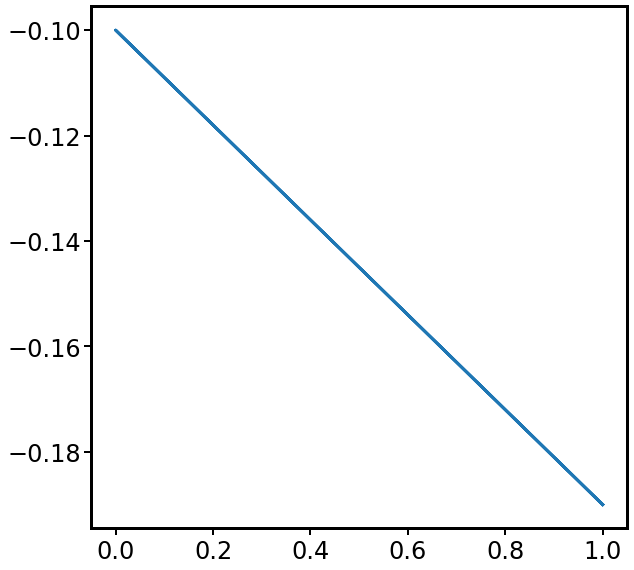

In [4]:
plt.plot(rawdata_df['MA fraction'],E_ads_O2/1.6e-19)

Text(0, 0.5, 'Bleaching Rate')

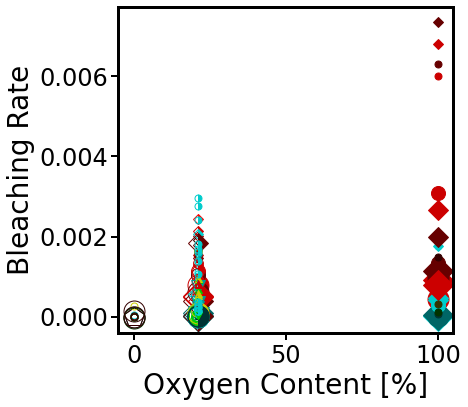

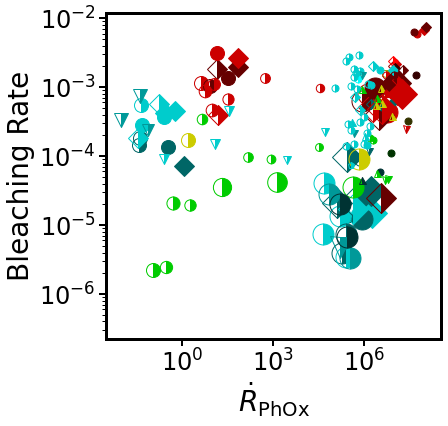

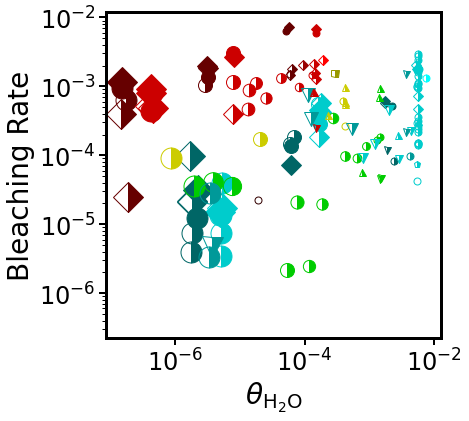

In [5]:
mpl.style.use('wiley_publication.mplstyle')

plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(rawdata_df['Oxygen (%)'].iloc[ii],rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('Oxygen Content [%]')
plt.ylabel('Bleaching Rate')

plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['PhotoOx_rate'].iloc[ii],rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('$\dot{R}_\mathrm{PhOx}$')
plt.ylabel('Bleaching Rate')

plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['Hydration_rate'].iloc[ii],rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('$\\theta_\mathrm{H_2O}$')
plt.ylabel('Bleaching Rate')

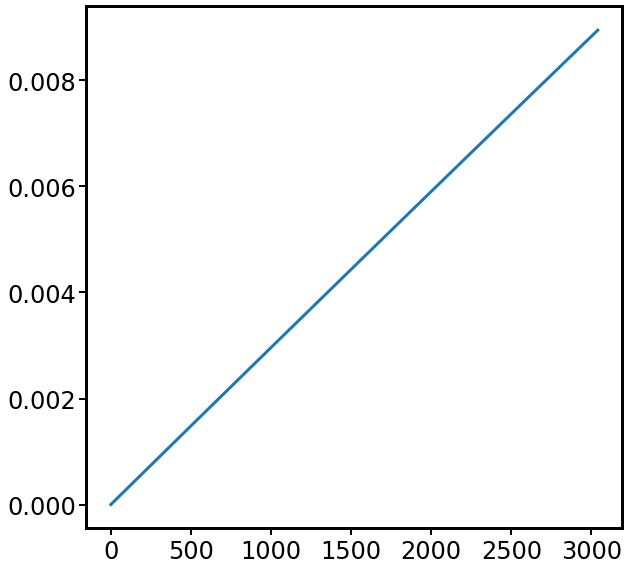

In [6]:
E_ads_H2O = -0.45*1.6e-19 # linear relationship based on composition
T_Kelvin = 298
P_H2O = np.linspace(0,101325*0.03,num=101)
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*P_H2O/(1 + Keq_H2O*P_H2O)

plt.plot(P_H2O,LAI_H2O)

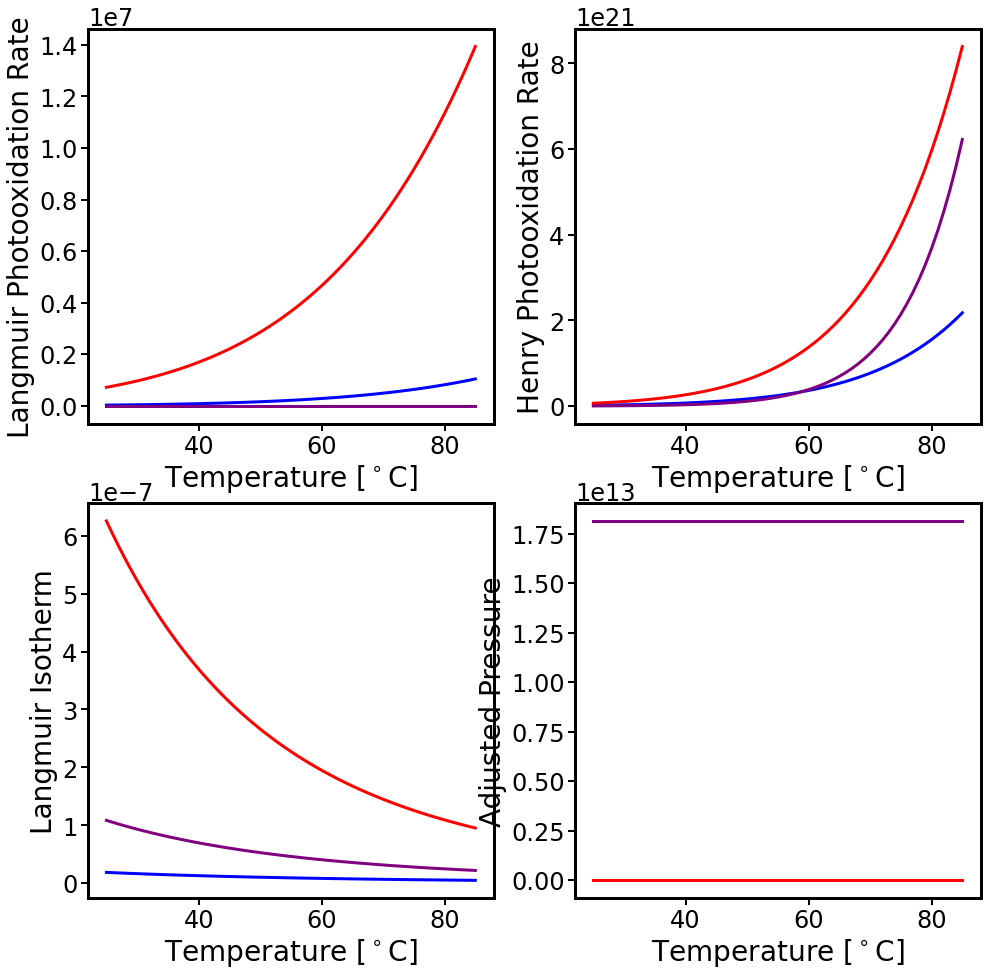

In [7]:
P_O2_base = 0.21*101325
T_Kelvin = np.linspace(25,85,num=61) + 273.15
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]

fig, ax = plt.subplots(2,2,figsize=(16,16))

for xMA in (0,0.5,1):
    E_ads_O2 = lambda x: (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*x)*1.6e-19 # linear relationship based on composition
    E_act_O2 = lambda x: Ea_fit[0]*x**2 + Ea_fit[1]*x + Ea_fit[2]
    PhOx_RC  = lambda x: np.exp(R0_fit[0]*x**2 + R0_fit[1]*x + R0_fit[2])

    # equilibrium constant for O2 adsorption [1/Pa]
    Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(xMA)/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

    # Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
    theta_O2 = Keq_O2*P_O2_base/(1+Keq_O2*P_O2_base)
    
    # CB and VB effective densities of states, 1/m3
    Nc = 2*((mc*kB*T_Kelvin)/(2*np.pi*h_bar**2))**(3/2)
    Nv = 2*((mv*kB*T_Kelvin)/(2*np.pi*h_bar**2))**(3/2)
    # intrinsic carrier density, 1/m3
    ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*T_Kelvin)))
    # excited carrier concentration, 1/m3
    n_exc = ni*np.sqrt(np.exp(1.2/(8.617e-5*T_Kelvin)))
    
    PhOxRate_Langmuir = theta_O2*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*T_Kelvin))
    PhOxRate_Henry = PhOx_RC(xMA)*P_O2_base*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*T_Kelvin))
    
    ax[0,0].plot(T_Kelvin-273.15,PhOxRate_Langmuir,color=(xMA,0,1-xMA))
    ax[0,0].set_xlabel('Temperature [$^\circ$C]')
    ax[0,0].set_ylabel('Langmuir Photooxidation Rate')
       
    ax[0,1].plot(T_Kelvin-273.15,PhOxRate_Henry,color=(xMA,0,1-xMA))
    ax[0,1].set_xlabel('Temperature [$^\circ$C]')
    ax[0,1].set_ylabel('Henry Photooxidation Rate')
    
    ax[1,0].plot(T_Kelvin-273.15,theta_O2,color=(xMA,0,1-xMA))
    ax[1,0].set_xlabel('Temperature [$^\circ$C]')
    ax[1,0].set_ylabel('Langmuir Isotherm')
       
    ax[1,1].plot(T_Kelvin-273.15,PhOx_RC(xMA)*P_O2_base*np.ones(len(T_Kelvin)),color=(xMA,0,1-xMA))
    ax[1,1].set_xlabel('Temperature [$^\circ$C]')
    ax[1,1].set_ylabel('Adjusted Pressure')

    

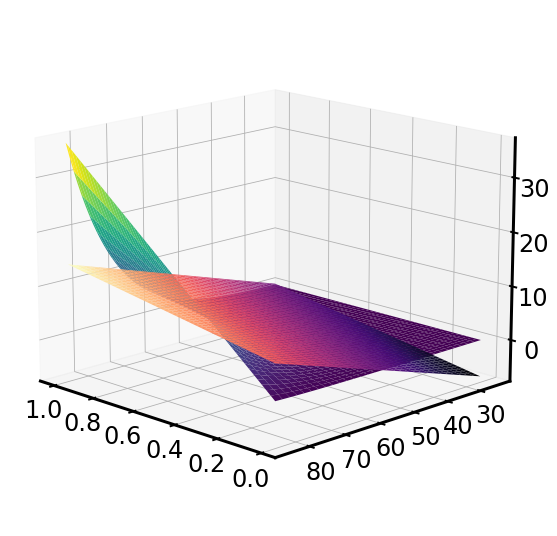

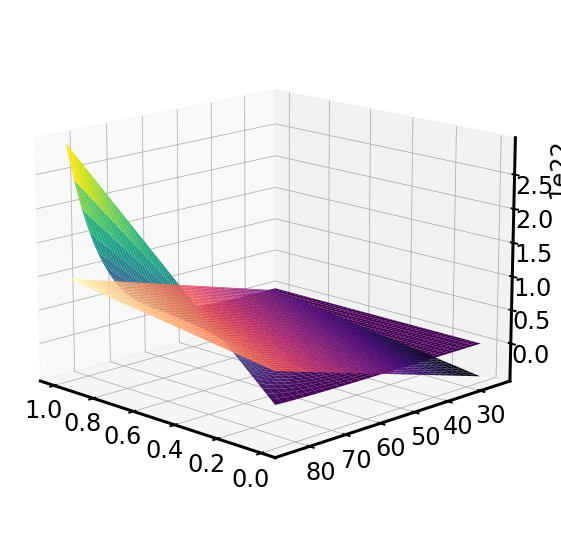

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Pressure and temperature ranges to plot
P_O2_base = np.linspace(0.01,1,num=100)*101325
T_Kelvin = np.linspace(25,85,num=61) + 273.15
# mesh the grid
PP,TT = np.meshgrid(P_O2_base,T_Kelvin,indexing='ij')

vQ_O2 = h**3*(2*np.pi*m_O2*kB*TT)**(-3/2) # quantum volume of O2 [m3]

#fig, ax = plt.subplots(2,2,figsize=(16,16))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#for xMA in (0,0.5,1):
    
xMA = 0.5

E_ads_O2 = lambda x: (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*x)*1.6e-19 # linear relationship based on composition
E_act_O2 = lambda x: Ea_fit[0]*x**2 + Ea_fit[1]*x + Ea_fit[2]
PhOx_RC  = lambda x: np.exp(R0_fit[0]*x**2 + R0_fit[1]*x + R0_fit[2])

# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(xMA)/(kB*TT))*(kB*TT)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
theta_O2 = Keq_O2*PP/(1+Keq_O2*PP)

# CB and VB effective densities of states, 1/m3
Nc = 2*((mc*kB*TT)/(2*np.pi*h_bar**2))**(3/2)
Nv = 2*((mv*kB*TT)/(2*np.pi*h_bar**2))**(3/2)
# intrinsic carrier density, 1/m3
ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*TT)))
# excited carrier concentration, 1/m3
n_exc = ni*np.sqrt(np.exp(1.2/(8.617e-5*TT)))

PhOxRate_Langmuir = theta_O2*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*TT))
PhOxRate_Henry = PhOx_RC(xMA)*PP*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*TT))
#PhOxRate_Henry = PP*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*TT))


ax.plot_surface(PP/101325,TT-273.15,PhOxRate_Langmuir,cmap=cm.viridis)

obs_list = []
for ii in range(PP.shape[0]):
    for jj in range (PP.shape[1]):
        obs_list.append([PP[ii,jj],TT[ii,jj],PhOxRate_Langmuir[ii,jj],PhOxRate_Henry[ii,jj]])

obs_DF = pd.DataFrame(obs_list,columns=['Pressure [Pa]','Temperature [K]','Langmuir','Henry'])



X = obs_DF[['Pressure [Pa]','Temperature [K]']]

Y = obs_DF['Langmuir']
reg = LinearRegression().fit(X,Y)
Langmuir_fit = reg.intercept_ + reg.coef_[0]*PP + reg.coef_[1]*TT
ax.plot_surface(PP/101325,TT-273.15,Langmuir_fit,cmap=cm.magma)
ax.view_init(15,135)


fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

Y2 = obs_DF['Henry']
reg2 = LinearRegression().fit(X,Y2)
Henry_fit = reg2.intercept_ + reg2.coef_[0]*PP + reg2.coef_[1]*TT
ax2.plot_surface(PP/101325,TT-273.15,PhOxRate_Henry,cmap=cm.viridis)

ax2.plot_surface(PP/101325,TT-273.15,Henry_fit,cmap=cm.magma)
ax2.view_init(15,135)


In [9]:
obs_DF.head

<bound method NDFrame.head of       Pressure [Pa]  Temperature [K]   Langmuir         Henry
0           1013.25           298.15   0.001034  1.726869e+17
1           1013.25           299.15   0.001164  2.002620e+17
2           1013.25           300.15   0.001308  2.320152e+17
3           1013.25           301.15   0.001468  2.685450e+17
4           1013.25           302.15   0.001648  3.105306e+17
...             ...              ...        ...           ...
6095      101325.00           354.15  26.196618  1.948299e+22
6096      101325.00           355.15  28.449143  2.165561e+22
6097      101325.00           356.15  30.880555  2.405651e+22
6098      101325.00           357.15  33.503852  2.670818e+22
6099      101325.00           358.15  36.332883  2.963516e+22

[6100 rows x 4 columns]>

# 3. Data Visualization - Nonlinearity

Make some box and whisker plots of the overall dataset to illustrate how the data vary nonlinearly with temperature and composition

Text(0, 0.5, '$\\ln(t_{L_\\mathrm{D},75})$')

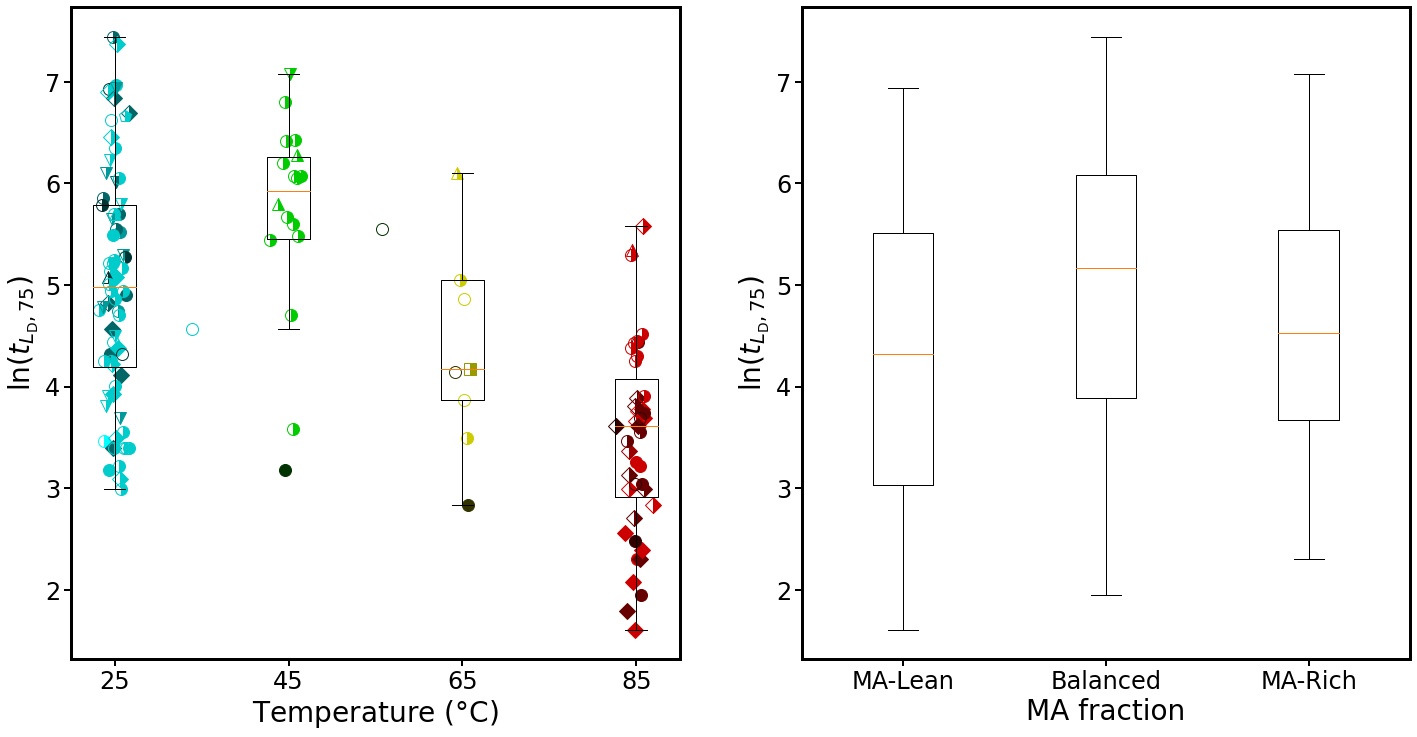

In [10]:
# Initialize the figure
fig, ax = plt.subplots(1,2,figsize=(24,12))

# temperature bins
T25 = []
T45 = []
T65 = []
T85 = []

# initialize bins for composition
MA_rich = []
MA_bal = []
MA_lean = []

# loop over datapoints in the DF
for ii in range(len(rawdata_df)):
    
    # get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    # grab composition
    xMA = rawdata_df['MA fraction'].iloc[ii]
    # grab tLD75
    y = np.log(rawdata_df['tLD75 (min)'].iloc[ii])
    
    # plot temperature with random jitter
    ax[0].plot(rawdata_df['Temp (deg C)'].iloc[ii]+random.gauss(0,0.75),y,
             color=color,fillstyle=fill,marker=marker,linestyle=style)
    # bin runs by temperature
    if T < 35:
        if not np.isnan(y):
            T25.append(y)
    elif T < 55:
        if not np.isnan(y):
            T45.append(y)
    elif T < 75:
        if not np.isnan(y):
            T65.append(y)
    else:
        if not np.isnan(y):
            T85.append(y)
    
    # and also by composition
    if xMA < 0.33:
        if not np.isnan(y):
            MA_lean.append(y)
    elif xMA >= 0.33 and xMA < 0.66:
        if not np.isnan(y):
            MA_bal.append(y)
    else:
        if not np.isnan(y):
            MA_rich.append(y)
            
# add the box and whisker plots for temperature...
ax[0].boxplot([T25,T45,T65,T85],positions=[25,45,65,85],widths=[5,5,5,5],showfliers=False)
ax[0].set_xlim([20,90])
ax[0].set_xlabel('Temperature ($\degree$C)')
ax[0].set_ylabel('$\ln(t_{L_\mathrm{D},75})$')

# ...and composition
ax[1].boxplot([MA_lean,MA_bal,MA_rich],labels=['MA-Lean','Balanced','MA-Rich'],showfliers=False)
ax[1].set_xlabel('MA fraction')
ax[1].set_ylabel('$\ln(t_{L_\mathrm{D},75})$')



# 4. Basic Plots of the Dataset - Contextualizing LD75

Before modeling, it is always advisable to analyze the dataset by visualization to better contextualize the predictions of the model. Here is where we make some plots for figures in the paper. 

(0.0, 25.0)

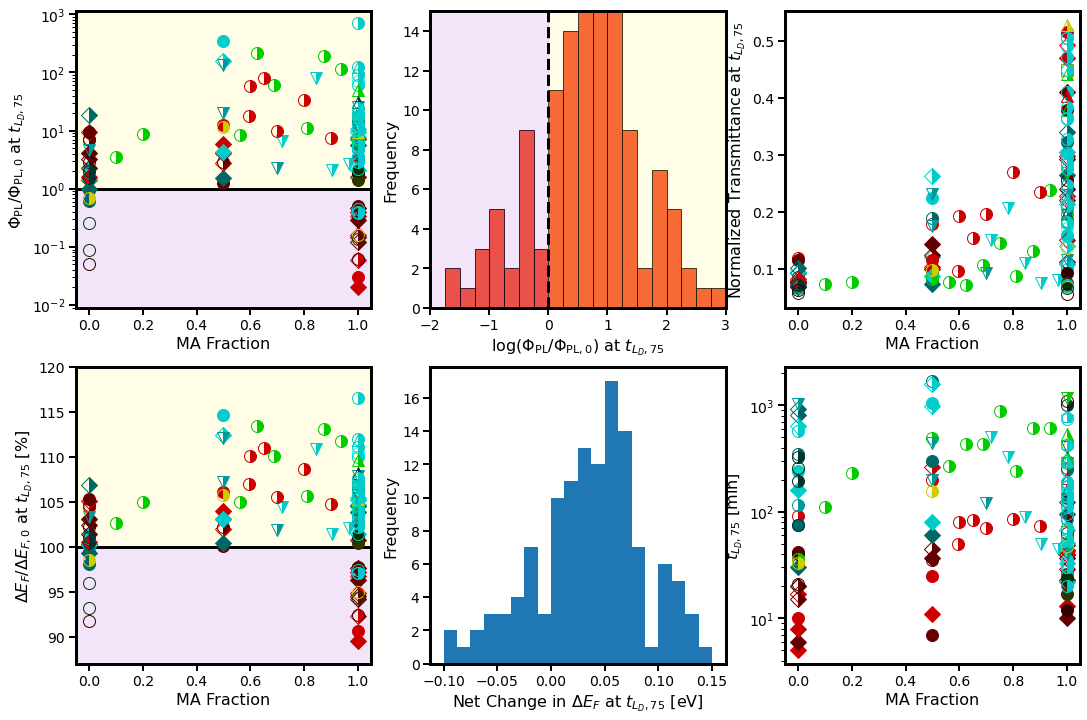

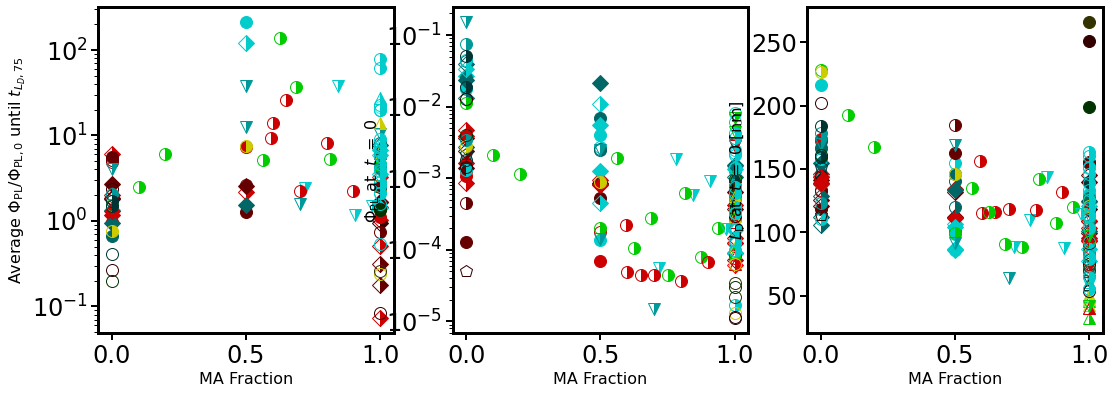

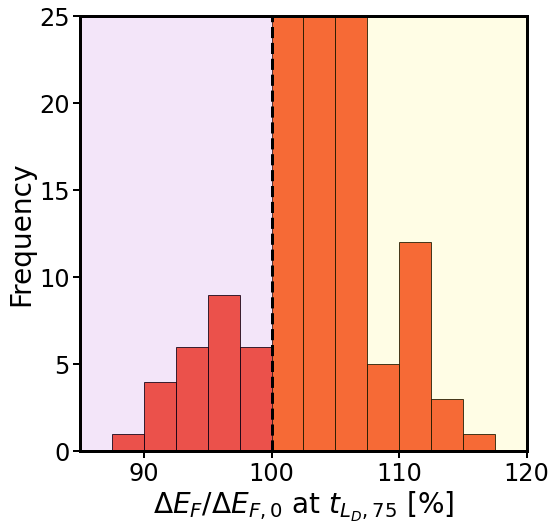

In [11]:
# Make some plots of the overall dataset
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(18,12))

def_fontsize = 16
def_labelsize = 14

ax00_xmin = -0.05
ax00_xmax = 1.05
ax00_ymin = 10**-2.05
ax00_ymax = 10**3.05

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,0].hlines(1,ax00_xmin,ax00_xmax,color='k',linestyles='-') # boundary
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymax,ax00_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymin,ax00_ymin],color=(0.56,0,0.8,0.1)) # darkened region


# set markers using environmental condition marker conventions
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    # plot PL enhancement at tLD75 vs composition
    ax[0,0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot QFLS enhancement at failure vs composition
    ax[1,0].plot(rawdata_df['MA fraction'].iloc[ii],100*(1 + 0.059*np.log10(rawdata_df['PLFail'].iloc[ii]/rawdata_df['QFLS_0'].iloc[ii])), 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot transmittance enhancement at failure vs composition
    ax[0,2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['TrFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot tLD75 vs. composition
    ax[1,2].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['tLD75 (min)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)

# labeling - top left plot
ax[0,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,0].set_ylabel('$\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,0].set_xlim(ax00_xmin,ax00_xmax)
ax[0,0].set_ylim(ax00_ymin,ax00_ymax)

# set parameters for bottom left plot - quasi-Fermi level splitting enhancement vs. composition
ax10_xmin = -0.1
ax10_xmax = 1.1
ax10_ymin = 85
ax10_ymax = 120
ax[1,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,0].set_ylabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,75}$ [%]',fontsize=def_fontsize)

# plot demarcations between QFLS enhancement vs. QFLS reduction
ax[1,0].hlines(100,ax10_xmin,ax10_xmax,color='k',linestyles='-') # boundary
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymax,ax10_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymin,ax10_ymin],color=(0.56,0,0.8,0.1)) # darkened region
ax[1,0].set_xlim([-0.05,1.05])
ax[1,0].set_ylim([87,120])

# set labels for top right plot - change in transmittance at tLD75
ax[0,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,2].set_ylabel('Normalized Transmittance at $t_{L_D,75}$',fontsize=def_fontsize)

# set labels for bottom right plot - LD75 vs composition
ax[1,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,2].set_ylabel('$t_{L_D,75}$ [min]',fontsize=def_fontsize)

# set dimensions for top middle panel - histogram of PL enhancements
ax[0,1].hist(np.log10(rawdata_df['PLFail'].dropna()),bins=np.linspace(-2,3,num=21),
             color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[0,1].set_xlabel('log($\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$) at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,1].set_ylabel('Frequency',fontsize=def_fontsize)

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,1].vlines(0,0,15,color='k',linestyles='--')
ax[0,1].fill([0,0,3,3],[0,15,15,0],color=(1,0.96,0,0.1)) # brightened region
ax[0,1].fill([0,0,-2,-2],[0,15,15,0],color=(0.56,0,0.8,0.1)) # brightened region
ax[0,1].set_xlim(-2,3)
ax[0,1].set_ylim(0,15)

# bottom middle plot - histogram of change in QFLS at failure
ax[1,1].hist(0.059*np.log10(rawdata_df['PLFail']),bins=np.linspace(-0.1,0.15,num=21))
ax[1,1].set_xlabel('Net Change in $\Delta E_F$ at $t_{L_D,75}$ [eV]',fontsize=def_fontsize)
ax[1,1].set_ylabel('Frequency',fontsize=def_fontsize)

# change the tick label sizes on all the panels
for ii in range(2):
    for jj in range(3):
        ax[ii,jj].tick_params(axis='x', labelsize=def_labelsize)
        ax[ii,jj].tick_params(axis='y', labelsize=def_labelsize)

# make a new figure
fig2,ax2 = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    ax2[0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLEnhance'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[1].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLQY_0'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['LD_0 (nm)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
ax2[0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[0].set_ylabel('Average $\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ until $t_{L_D,75}$',fontsize=def_fontsize)
    
ax2[1].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[1].set_ylabel('$\Phi_\mathrm{PL}$ at  $t\ =\ 0$',fontsize=def_fontsize)    

ax2[2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[2].set_ylabel('$L_\mathrm{D}$ at  $t\ =\ 0$ [nm]',fontsize=def_fontsize)

fig3, ax3 = plt.subplots(figsize=(8,8))
ax3.hist((100*(1 + 0.059*np.log10(rawdata_df['PLFail']/rawdata_df['QFLS_0']))).dropna(), 
         bins = np.linspace(85,120,num=15),color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax3.set_xlabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,75}$ [%]')
ax3.set_ylabel('Frequency')

# partition graph between regions where PL has brightened/has darkened at LD75
ax3.vlines(100,0,25,color='k',linestyles='--')
ax3.fill([100,100,120,120],[0,25,25,0],color=(1,0.96,0,0.1)) # brightened region
ax3.fill([100,100,85,85],[0,25,25,0],color=(0.56,0,0.8,0.1)) # brightened region
ax3.set_xlim(85,120)
ax3.set_ylim(0,25)

(array([ 22.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40., 112.]),
 array([-30.        , -27.21299859, -24.42599719, -21.63899578,
        -18.85199438, -16.06499297, -13.27799157, -10.49099016,
         -7.70398875,  -4.91698735,  -2.12998594]),
 <BarContainer object of 10 artists>)

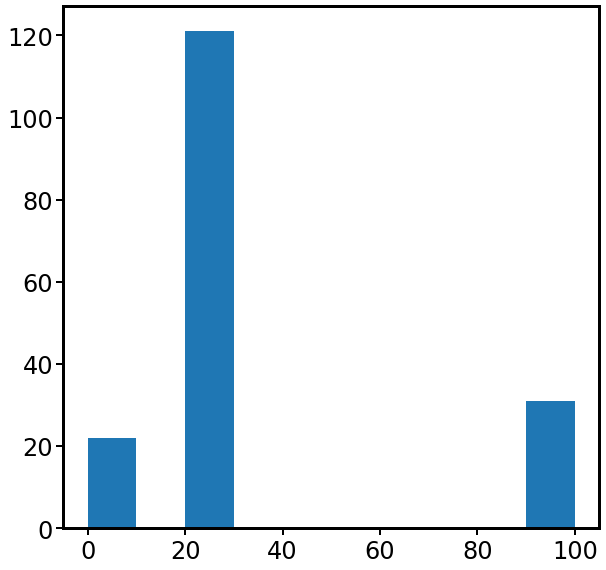

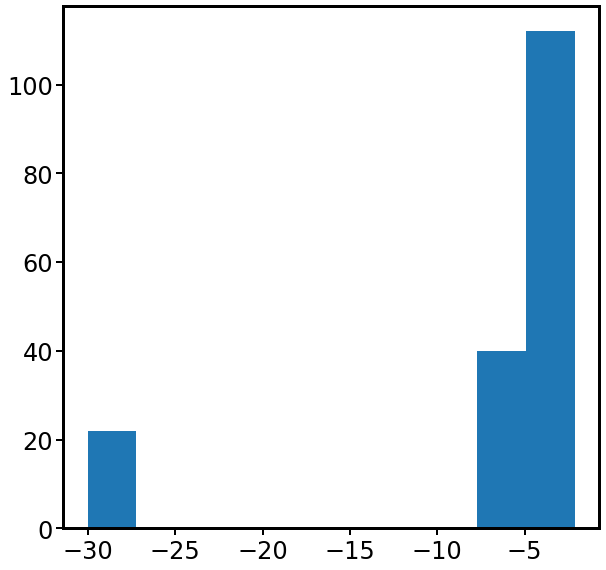

In [12]:
plt.hist(rawdata_df['Oxygen (%)'])

plt.figure()
plt.hist(np.log10(rawdata_df['Hydration_rate'] + 1e-30))

# 5. Feature Pre-Selection

In this cell, set up the machine learning task by deciding which of the above attributes to use as the response (i.e., variable to predict) and which to use as the features and which to ignore. It is also possible to construct interaction-related features, such as those between environment and composition.

In [13]:
# rawdata_df = rawdata_df[rawdata_df['ClassID'] == '200525_Replication_Study']
# rawdata_df = rawdata_df[rawdata_df['MA fraction'] == 1]
# rawdata_df = rawdata_df[rawdata_df['Illum (Nsuns)'] == 8]
rawdata_df = rawdata_df[rawdata_df['Oxygen (%)'] > 0]

# change to True if using a log transform on the response
Log_transform = True

# choose the feature to use as the response
#response = 'Bleach Rate (fit to 5% inc) (1/min)' 
# response = 'Bleach Rate (polyfit) (1/min)' 
response = 'tLD75 (min)'
#response = 'tPLmax'
#response = 'PL0'

# assign factor labels to each stress
factor_dict = {'A':'Temp (deg C)',
               'B':'RH (%)',
               'C':'Oxygen (%)',
               'D':'Illum (Nsuns)',
               'E':'MA fraction',
               'dTrdt':'Bleach Rate (polyfit) (1/min)',
               'dLDdt':'dLDdt (1/min)',
               'dPLdt':'dPLdt (1/min)',
               'LD0':'LD_0 (nm)',
               'PL0':'PLQY_0'}

factor_dict_inv = {'Temp (deg C)':'A',
                   'RH (%)':'B',
                   'Oxygen (%)':'C',
                   'Illum (Nsuns)':'D',
                   'MA fraction':'E',
                   'Bleach Rate (polyfit) (1/min)':'dTrdt',
                   'dLDdt (1/min)':'dLDdt',
                   'dPLdt (1/min)':'dPLdt',
                   'LD_0 (nm)':'LD0',
                   'PLQY_0':'PL0'}

# choose environment, composition, AND early time features

# PL heterogeneity terms to choose from, if desired:
# spatiotemporal = ['xy1t0_0','xy0t1_0','xy1t1_0','t0xy1_0','t1xy0_0','frac_bright_0']


# Features to use, for historical reasons termed "Ryan features"
Ryan_features = ['dTrdt','dLDdt','dPLdt', # features used in ACSEL paper
                 'ddTr0','ddLD0','ddPL0', # features used in ACSEL paper
                 #'dLDdt','dPLdt', # features used in ACSEL paper
                 #'ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5', # features used in ACSEL paper
                 'Tr1','Tr2','Tr3','Tr4','Tr5', # features used in ACSEL paper
                 'PL1','PL2','PL3','PL4','PL5', # features used in ACSEL paper
                 'A','P_H2O','P_O2','D','E', # linear environment and composition
#                 'A','P_H2O','D','E', # linear environment and composition
#                 'P_H2O','D','E', # linear environment and composition                 
#                 'PhotoOx_rate','Hydration_rate'] # physics-inspired features
                 'PhotoOx_rate','Hydration_rate','delS_mix',]
#                 'PhotoOx_rate','Ox_rate_P','Hydration_rate','delS_mix',]

# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)


# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)


   
# display the modeling-ready dataset head    
coded_df.head()

Number of Runs Total: 152
Number of Runs That Fail After Prediction Horizon: 122


A     D    E     dTrdt  tLD75 (min)     dLDdt     dPLdt     ddTr0  \
0  65.0  16.0  1.0  0.001621         65.0  0.012592  0.144281  0.000046   
1  85.0  32.0  1.0  0.002031         29.0  0.010210  0.102848  0.000030   
2  85.0  32.0  1.0  0.001560         40.0 -0.016537 -0.093627  0.000033   
3  85.0  32.0  1.0  0.002267         44.0 -0.017553  0.133394  0.000101   
4  85.0  32.0  1.0  0.001523         49.0 -0.017441 -0.131137  0.000026   

      ddPL0     ddLD0  ...       PL1       PL2       PL3       PL4       PL5  \
0 -0.029782  0.003579  ...  1.235488  1.356202  1.481278  1.598510  1.712102   
1 -0.034643  0.000074  ...  1.195564  1.298063  1.373613  1.425215  1.452358   
2  0.183605  0.002057  ...  0.322036  0.383425  0.426699  0.479533  0.490416   
3 -0.032885 -0.001562  ...  1.187610  1.335641  1.471436  1.525058  1.525773   
4  0.161826 -0.001746  ...  0.374623  0.305578  0.327652  0.367803  0.401406   

         P_H2O      P_O2  PhotoOx_rate  Hydration_rate  delS_mix  
0  1304.224576  21278.25  5.556998e+06        0.000292       0.0  
1  1247.381858  21278.25  9.606616e+06        0.000094       0.0  
2  1910.546896  21278.25  1.204581e+07        0.000144       0.0  
3  1872.651751  21278.25  1.203632e+07        0.000141       0.0  
4   783.166331  21278.25  1.469949e+07        0.000059       0.0  

[5 rows x 30 columns]

# 6. Modeling

In this cell, the machine learning model is initialized and trained. Error metrics and coefficients are calculated and tabulated for visualization in the cells below.

{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
For test set:
Mean of Mean Absolute Error = 13.7 %
Median of Mean Absolute Error = 9.5 %
Std. Dev. of Mean Absolute Error = 12.7 %
Mean of Mean Absolute Error = 0.588
Median of Mean Absolute Error = 0.468
Std. Dev. of Mean Absolute Error = 0.483
Mean R2 = nan
Median R2 =

C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


 nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 11.2 %
Median of Mean Absolute Error = 11.2 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.492
Median of Mean Absolute Error = 0.493
Std. Dev. of Mean Absolute Error = 0.004
Mean R2 = 0.7727
Median R2 = 0.7729
Std Dev. R2 = 0.0025
Mean Linear Error = 73.0 %
Median Linear Error = 44.0 %
Index of Median Model: 63
{'alpha': 0.025118864315095808}


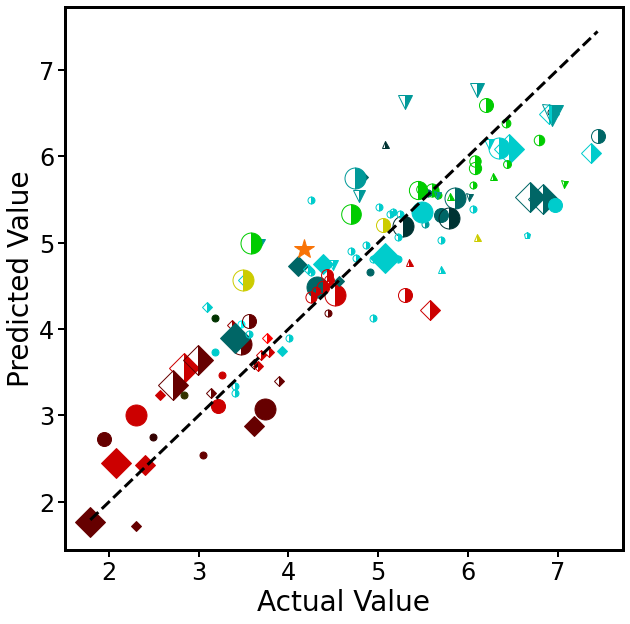

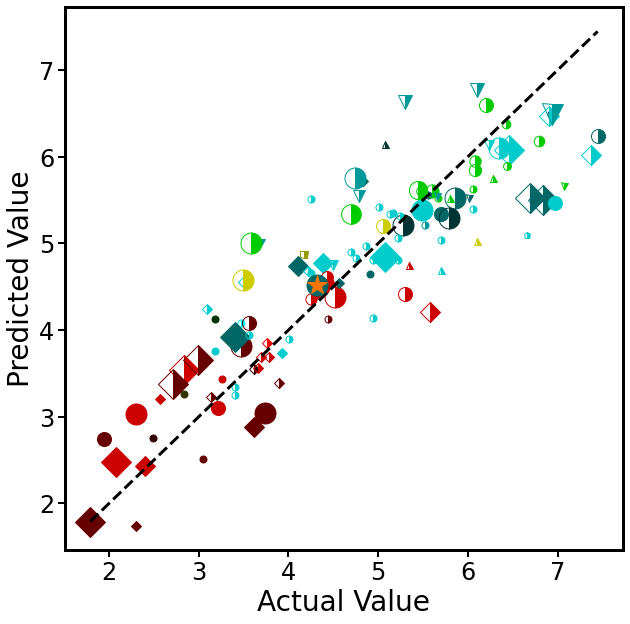

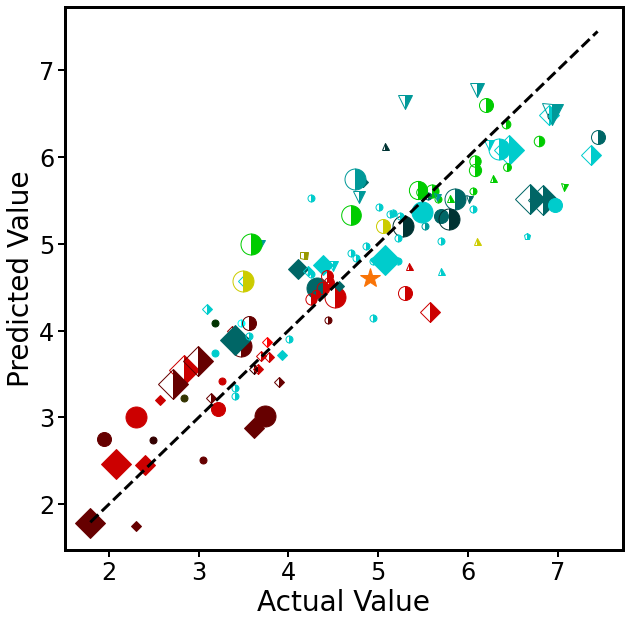

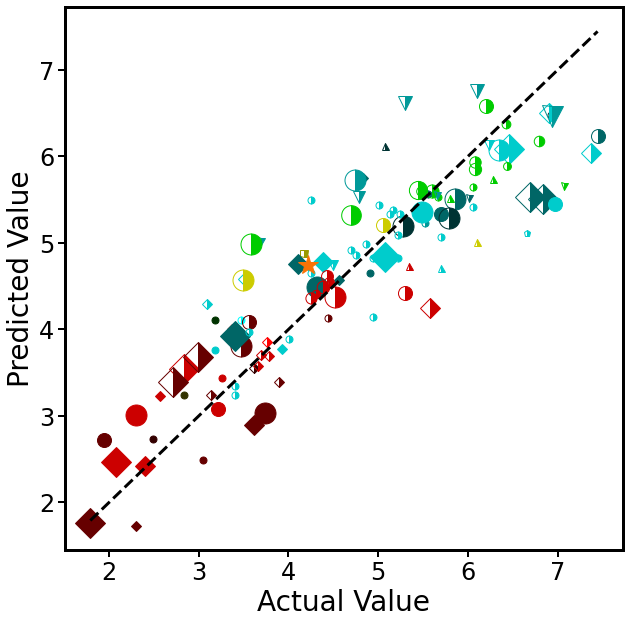

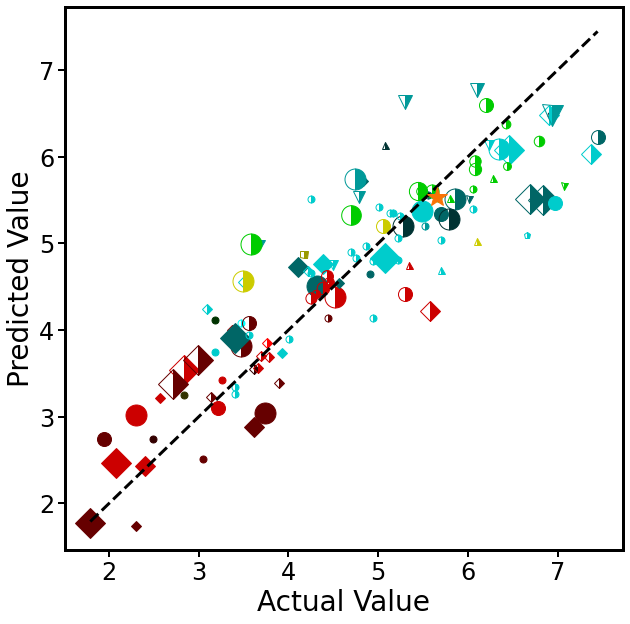

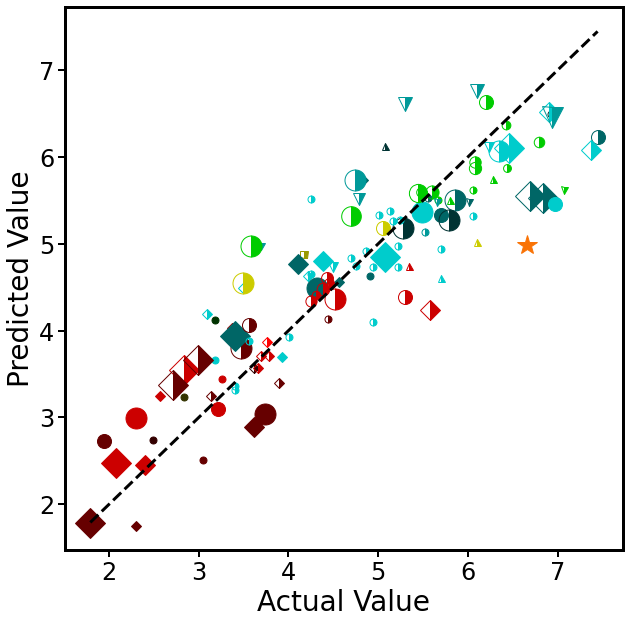

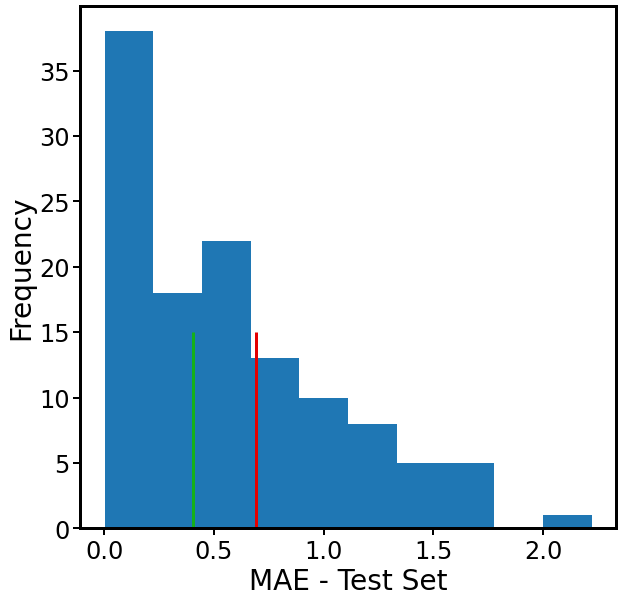

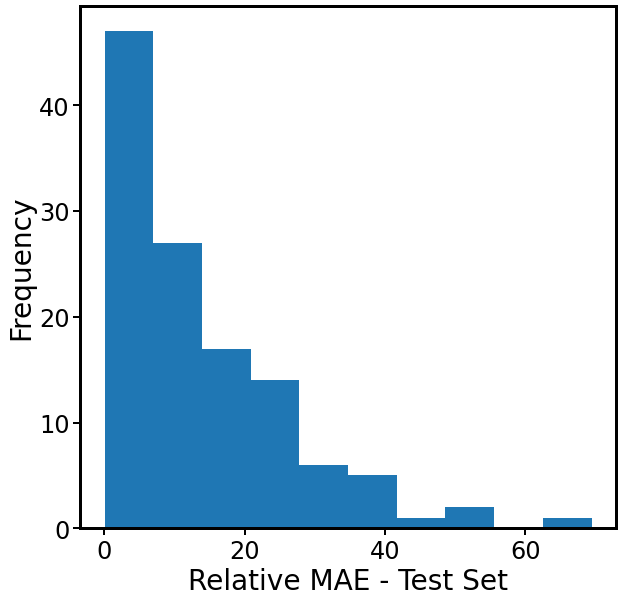

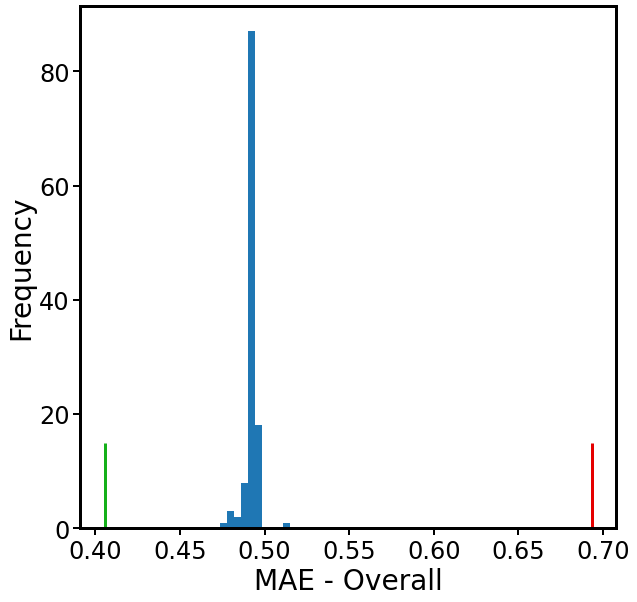

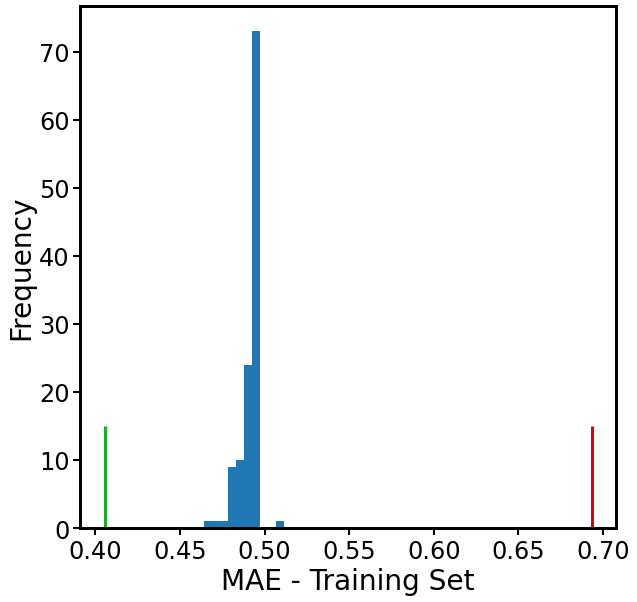

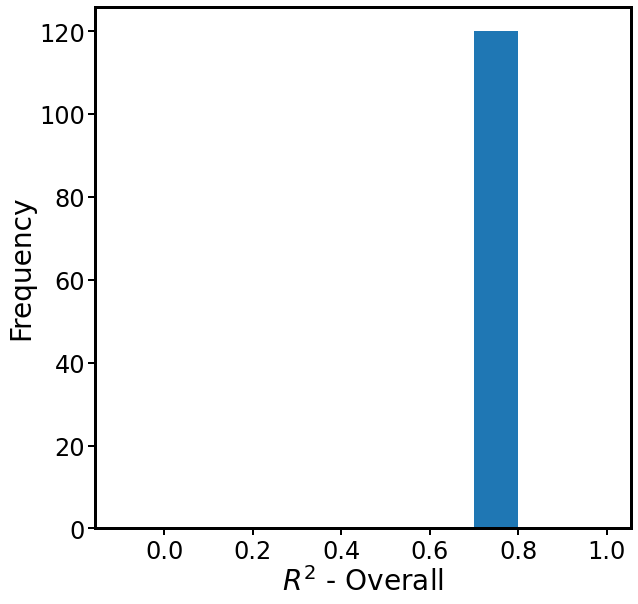

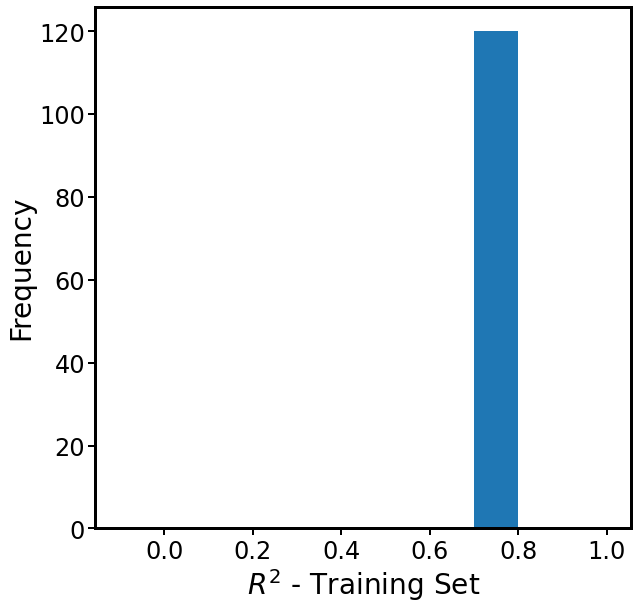

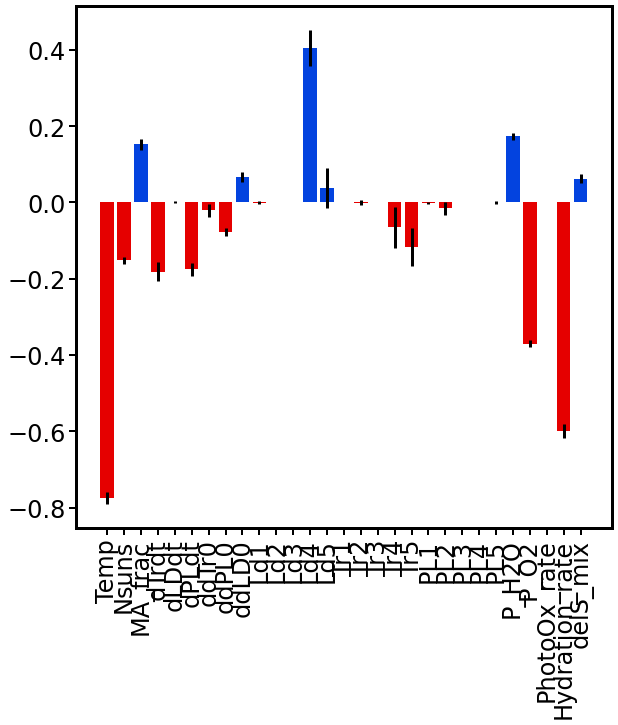

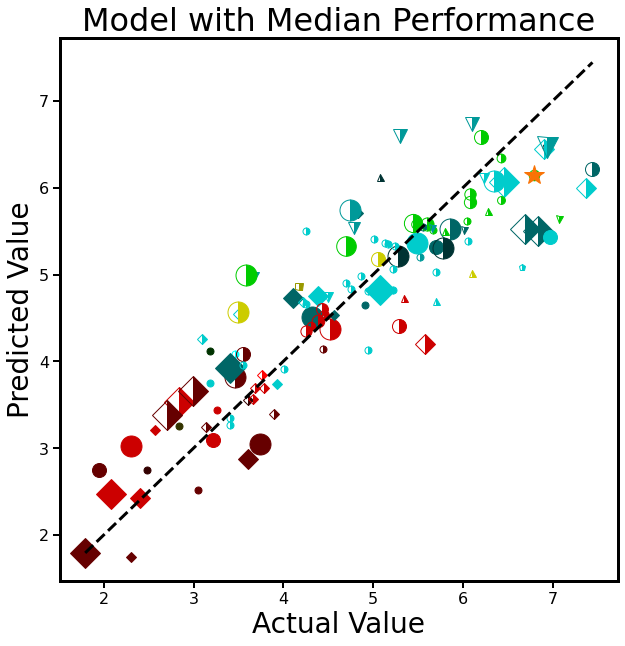

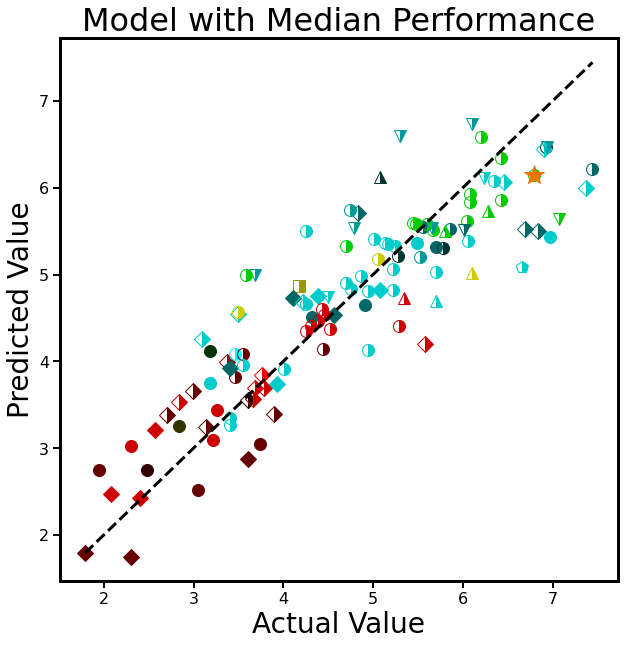

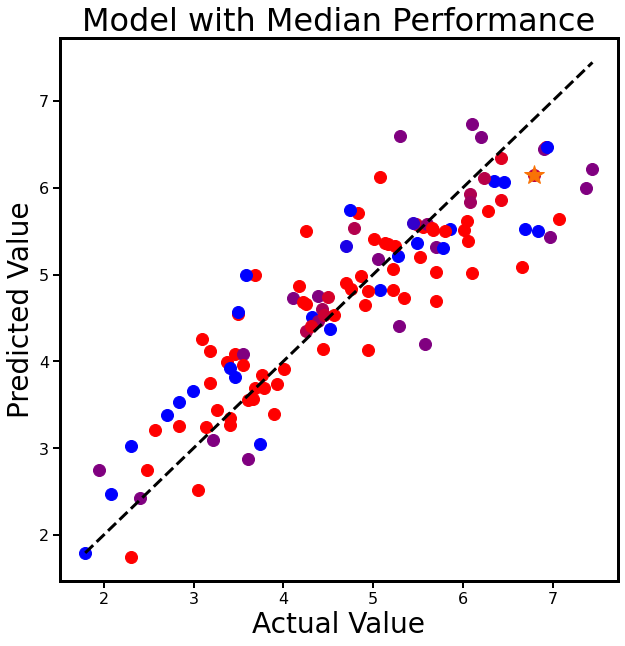

In [14]:
# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform on the response or not, 
# then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []

# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)
    
    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']
    
    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)
    
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    
    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])
    
    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)
    
    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)
    
    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    
    # plot training data with markers corresponding to environmental + compositional conditions
    if kk%20 == 0: # only do this for a few models to save memory
        
        plt.figure(figsize=(10,10))
        for ii in range(len(y_train)):
            idx = y_train.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            # and plot
            plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value
            
        # plot perfect prediction line and +/-50% error bounds
        plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
        plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
        
        # put labels on the axes
        plt.xlabel('Actual Value')
        plt.ylabel('Predicted Value')

        # plot test data as above
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                
    
    # save the model coefficients to the respective row in the DF
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))
    
#     # calculate and save Shapley values
#     shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
#     Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))
    
#     # sensitivity analysis for feature removal
    
#     # re-initialize a list for keeping track of error with feature deleted
#     d_error_missing_feats_per_obv = []
    
#     # loop over features
#     for col in X_train.columns:

#         # drop each feature
#         X_train_reduced = X_train.drop(columns=col).copy()
#         X_whold_reduced = X_whold.drop(col).copy()

#         # set alpha/lambda/penalty hyperparameter
#         regressor.fit(X_train_reduced,y_train)
#         alpha = regressor.best_params_['alpha']

#         # train the final model on the full training set
#         final_model_red = Lasso(alpha=alpha)
#         final_model_red.fit(X_train_reduced,y_train)

#         # make predictions on the test and training data
#         ypred=final_model_red.predict(np.array(X_whold_reduced).reshape(1,-1))

#         # calculate error metrics on test set with the missing feature
#         # and append it to the error list
#         d_error_missing_feats_per_obv.append(np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100) - MAE_pct[kk])

        
#     # save the error with deleted features
#     d_error_missing_feats.append(d_error_missing_feats_per_obv)

# # convert the change in error with missing features to a dataframe from epi-list
# missing_feats_DF = pd.DataFrame(d_error_missing_feats,columns=coded_df.drop(columns=response).columns)    

# plot histogram of absolute test set error
plt.figure()
plt.hist(MAE)
plt.xlabel('MAE - Test Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of percent test set error
plt.figure()
plt.hist(MAE_pct)
plt.xlabel('Relative MAE - Test Set')
plt.ylabel('Frequency')

# plot histogram of absolute full set error
plt.figure()
plt.hist(MAE_overall)
plt.xlabel('MAE - Overall')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of absolute training set error
plt.figure()
plt.hist(MAE_train)
plt.xlabel('MAE - Training Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of full set R2
plt.figure()
plt.hist(R2_overall,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Overall')
plt.ylabel('Frequency')

# plot histogram of training set R2
plt.figure()
plt.hist(R2_train,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Training Set')
plt.ylabel('Frequency')

# plot distribution of coefficients...
plt.figure()

# convert labels "A", "B", etc. back to physically meaningful names
new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}
coeffs_df.rename(columns = new_dict, inplace = True)

coeffs = coeffs_df.columns # save coefficient names
avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations

# assign colors to coefficient bars based on sign:
# red: accelerates degradation
# blue: decelerates degradation
# (these have different signs depending on what the response is)
bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

# plot the coefficients
plt.bar(coeffs,avgs,yerr=error,color=bar_colors)
plt.xticks(rotation=90) # make the labels legible

# Print important test statistics
print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
print('Median Linear Error =',np.round(np.median(linear_error)),'%')


##### Below this line is the code for plotting the performance of the median model

# identify the index corresponding to the median mean test error
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
print('Index of Median Model:',idx)

# partition the dataset - note the manipulations necessary to convert the index derived from 
# the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
kk = idx
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()

# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
ytpred=final_model.predict(X_train)

####### PLOT THE MEDIAN MODEL ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above, with environment denoted by marker appearance and composition by marker size
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    
####### PLOT THE MEDIAN MODEL - ALTERNATIVE STYLE ##############
# i.e., separate plots encoding environment and composition

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

##### COMPOSITION AS ONLY DISTINGUISHING FEATURE    

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 

In [76]:
bars_df

A         D         E     dTrdt     dLDdt     dPLdt     ddTr0  \
0     0.397906  0.568930  2.412765  1.155724  0.000080  0.837542  1.150610   
1    10.574555  4.936242  1.840536  3.286687  0.707009  0.264852  1.373553   
2     1.006951  2.455273  0.970704  0.207116  0.067693  1.401695  0.015907   
3     3.080869  4.732537  1.682741  3.219416  0.638576  0.317484  1.029529   
4     4.744403  1.311958  4.944119  0.118637  4.132023  6.099317  6.278743   
..         ...       ...       ...       ...       ...       ...       ...   
127   2.970464  0.393953  0.881274  0.757597  0.000215  2.240407  0.000353   
128   4.991707  0.310024  1.056300  0.487035  0.000396  1.092735  0.000146   
129   3.011099  0.983648  0.843945  0.302648  0.000196  0.183528  0.000041   
130   3.228960  0.500889  0.946470  0.425176  0.000030  1.056442  0.000074   
131   2.554289  0.545972  0.841023  0.060172  0.000037  0.204241  0.000042   

        ddPL0     ddLD0           Ld1  ...           PL1           PL2  \
0    2.674832  2.488855  1.901869e-05  ...  9.641834e-05  1.714221e-01   
1    0.674792  0.259888  8.506090e-08  ...  6.218219e-08  3.919346e-07   
2    3.189053  1.388134  3.605092e-06  ...  3.651555e-06  1.781814e-05   
3    1.434035  0.349651  4.132572e-06  ...  8.454927e-06  1.438819e-05   
4    4.651905  3.133230  1.866087e-04  ...  7.398207e-05  1.308044e-04   
..        ...       ...           ...  ...           ...           ...   
127  0.281069  0.014317  9.536213e-05  ...  1.591267e-04  4.670601e-01   
128  0.752964  0.920339  2.779621e-04  ...  2.229510e-04  5.483465e-01   
129  0.113624  0.274411  1.138129e-05  ...  1.546889e-04  2.999917e-01   
130  0.181603  0.385535  1.152760e-04  ...  1.156047e-04  1.087252e-01   
131  0.010636  0.164352  2.272346e-05  ...  6.609426e-05  1.148253e-01   

              PL3           PL4           PL5     P_H2O       P_O2  \
0    3.421673e-05  2.581514e-05  1.105828e-04  0.613875   3.137069   
1    2.887534e-08  2.292457e-08  6.050159e-07  0.474851   2.578343   
2    1.388084e-06  1.034444e-06  5.193199e-06  0.398252   0.064456   
3    1.416506e-06  1.144765e-06  5.966478e-06  2.581501  10.057889   
4    1.115985e-05  8.263065e-06  4.280405e-05  1.867429   1.658814   
..            ...           ...           ...       ...        ...   
127  1.797847e-05  1.655999e-05  2.635151e-05  0.009248   0.735639   
128  6.706135e-05  4.744485e-05  2.928914e-04  0.162900   0.656338   
129  2.198778e-05  1.762449e-05  1.042761e-04  0.160363   1.250962   
130  2.309394e-05  2.132551e-05  1.116823e-04  0.028010   1.048293   
131  1.312828e-05  9.939680e-06  5.134832e-05  0.150217   1.220188   

     PhotoOx_rate  Hydration_rate  delS_mix  
0    3.058825e-05        8.242147  1.338103  
1    6.402696e-07        5.682187  0.761635  
2    2.619659e-06        5.983110  1.549260  
3    2.474108e-06        7.198546  0.788741  
4    2.218631e-05        5.291172  1.169903  
..            ...             ...       ...  
127  5.554374e-05        5.425530  0.105601  
128  5.536533e-05        6.205134  0.286960  
129  3.251330e-05        8.378547  0.256613  
130  4.870949e-05        6.736532  0.136773  
131  2.061404e-05        6.277829  0.104400  

[132 rows x 29 columns]

In [26]:
X_train

A   D   E     dTrdt     dLDdt     dPLdt     ddTr0     ddPL0     ddLD0  \
78  NaN NaN NaN -0.016890  3.279050  3.949525 -0.446862  3.560674  0.753109   
79  NaN NaN NaN -0.656312 -0.716827 -0.425778 -0.403318  0.055917  0.824581   
80  NaN NaN NaN -0.826595 -0.445381 -0.424534 -0.896944 -0.059237  0.008702   
159 NaN NaN NaN  1.713874 -1.080471 -0.343012  0.277233  0.178133 -3.636793   
160 NaN NaN NaN  2.223920 -0.567355 -0.107187  1.422878  1.090910  1.217830   
161 NaN NaN NaN  1.282666 -0.468723 -0.327815  2.436844 -0.245274 -0.420647   
162 NaN NaN NaN  0.311818 -0.070921 -0.333322  0.428163 -0.740671 -0.280333   
163 NaN NaN NaN  0.781913 -0.610423 -0.415071  0.389662 -0.094234 -0.206602   
164 NaN NaN NaN  1.099778  1.643604 -0.279650  1.945240 -0.705725 -0.182816   
165 NaN NaN NaN -0.595543 -0.391400 -0.233651 -0.421890 -0.580614  0.063650   
167 NaN NaN NaN -0.844701 -0.364818 -0.268832 -0.838199 -0.075381  0.159044   
168 NaN NaN NaN -0.747839 -0.132469  0.239579 -0.796915 -0.290898  0.105434   
169 NaN NaN NaN -0.647541  0.197033 -0.119679 -0.288522 -1.045155  0.498357   
170 NaN NaN NaN -0.761373 -0.602531 -0.087998 -0.609164 -0.559938  0.472121   
171 NaN NaN NaN -0.849343  0.089059 -0.284270 -0.776381  0.023346  0.069698   
172 NaN NaN NaN -0.817747  0.073930 -0.200175 -0.924038 -0.335389  0.133452   
173 NaN NaN NaN -0.650087  0.168642 -0.338130 -0.497787 -0.176464  0.421212   

          Ld1  ...       PL1       PL2       PL3       PL4       PL5  \
78   2.187067  ...  2.872029  3.841491  3.930901  3.942478  3.964251   
79  -1.287777  ... -1.180304 -0.589763 -0.467930 -0.444099 -0.397344   
80  -0.541401  ... -1.096020 -0.555192 -0.450077 -0.445776 -0.414961   
159  1.704350  ... -0.932731 -0.530792 -0.403154 -0.346990 -0.295589   
160 -1.256403  ... -0.665804 -0.472213 -0.291399 -0.060529 -0.118371   
161 -0.165047  ... -0.229122 -0.316037 -0.333377 -0.324124 -0.222257   
162 -0.230111  ...  0.210937 -0.162473 -0.270674 -0.337385 -0.410079   
163 -0.452114  ... -0.822479 -0.510632 -0.442129 -0.424741 -0.384444   
164  2.019735  ...  0.879891  0.161250 -0.210454 -0.260367 -0.309763   
165 -0.558797  ...  0.112556 -0.099856 -0.177868 -0.242506 -0.257551   
167 -0.520447  ... -0.503727 -0.354572 -0.288526 -0.273066 -0.248202   
168 -0.205540  ...  1.315567  0.401767  0.279142  0.270753  0.159636   
169 -0.056648  ...  0.704610  0.148064  0.008966 -0.135807 -0.188888   
170 -0.859579  ...  0.293439  0.001590 -0.025621 -0.096802 -0.154196   
171  0.224308  ... -0.753676 -0.403950 -0.313218 -0.294774 -0.256649   
172 -0.010670  ...  0.149744 -0.155107 -0.185867 -0.192727 -0.183737   
173  0.009075  ... -0.354909 -0.403573 -0.358715 -0.333537 -0.281855   

        P_H2O  P_O2  PhotoOx_rate  Hydration_rate  delS_mix  
78  -1.997849   NaN     -1.328190       -1.997810       NaN  
79  -3.040586   NaN     -0.938036       -3.040756       NaN  
80   1.726212   NaN     -1.004305        1.725896       NaN  
159  0.236587   NaN     -0.148886        0.236619       NaN  
160  0.236587   NaN     -0.905753        0.236619       NaN  
161  0.236587   NaN     -0.547972        0.236619       NaN  
162  0.236587   NaN      2.114959        0.236619       NaN  
163  0.236587   NaN     -0.547144        0.236619       NaN  
164  0.236587   NaN     -0.444481        0.236619       NaN  
165  0.236587   NaN      0.554311        0.236619       NaN  
167  0.236587   NaN      1.124205        0.236619       NaN  
168  0.236587   NaN     -0.788862        0.236619       NaN  
169  0.236587   NaN      1.848920        0.236619       NaN  
170  0.236587   NaN      1.018982        0.236619       NaN  
171  0.236587   NaN     -0.542572        0.236619       NaN  
172  0.236587   NaN      0.538455        0.236619       NaN  
173  0.236587   NaN     -0.003630        0.236619       NaN  

[17 rows x 29 columns]

C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0, 0.5, 'Mean Increase in Test Set Error as a Result of Dropping Feature [%]')

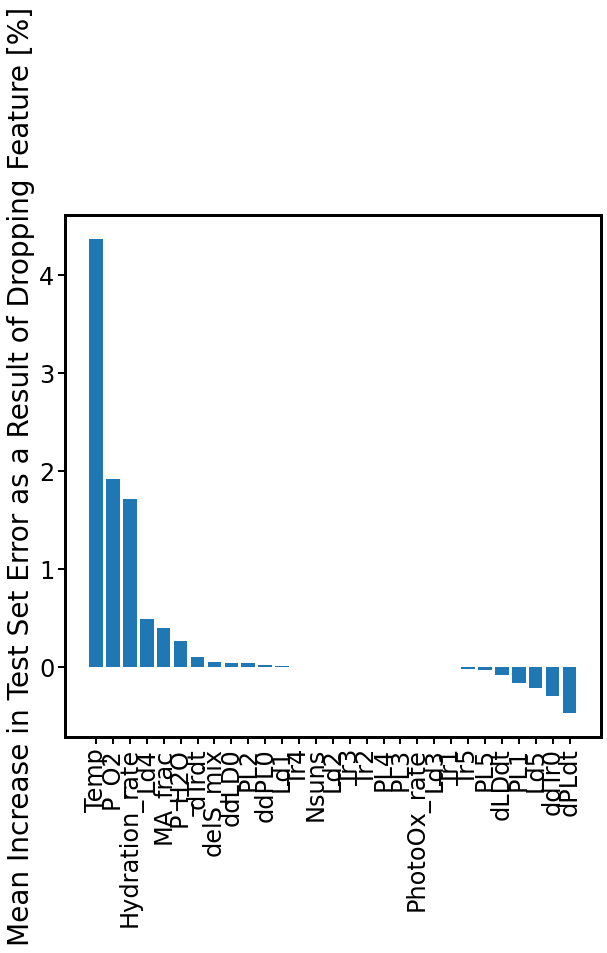

In [79]:
# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(np.mean(missing_feats_DF)) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = missing_feats_DF.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = bars_df['means'] # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('Mean Increase in Test Set Error as a Result of Dropping Feature [%]')

C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, '|Feature Shapley Value|')

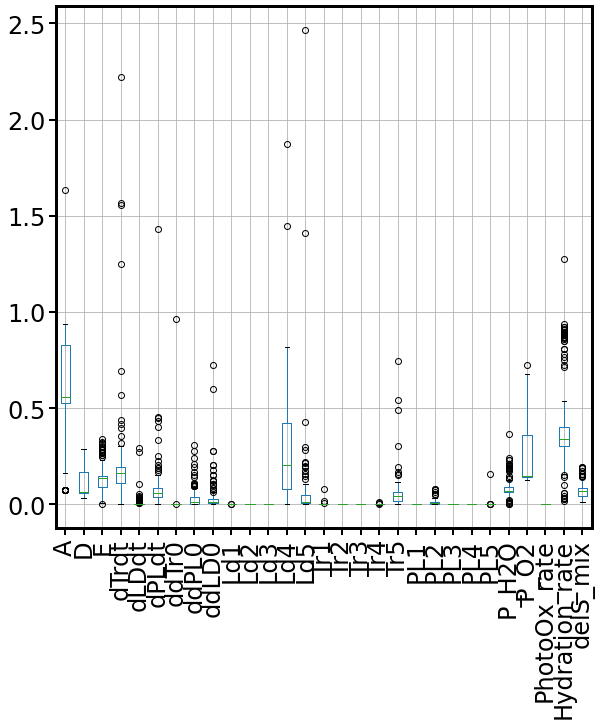

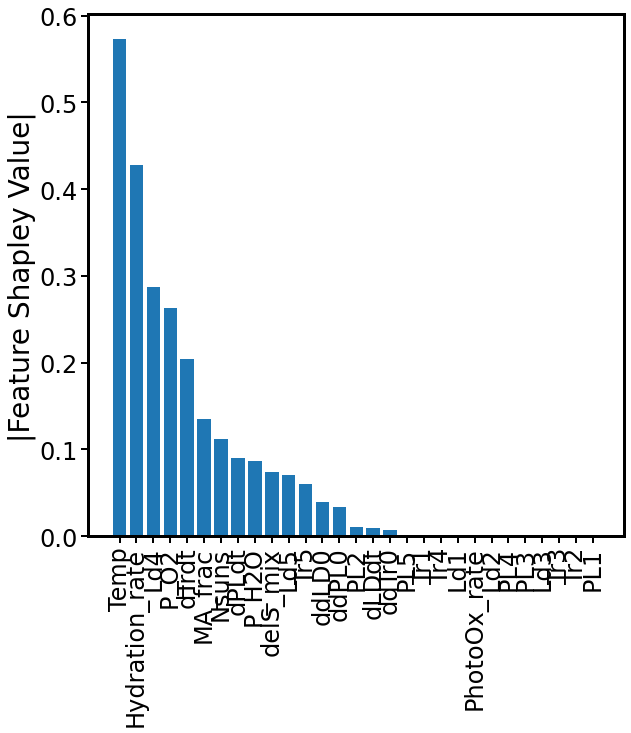

In [80]:
import seaborn as sns

shvals_mean = np.mean(Shap_vals_df)
#plt.bar(Shap_vals_df.columns,shvals_mean)
#ax=plt.gca()
#ax.set_xticklabels(Shap_vals_df.columns,rotation=90)


Shap_vals_abs = Shap_vals_df.copy()
for col in Shap_vals_abs.columns:
    vals = Shap_vals_abs[col].values
    vals = np.abs(vals)
    Shap_vals_abs[col] = vals
    
Shap_vals_abs.boxplot(rot=90)
abs_means = np.mean(Shap_vals_abs)

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(abs_means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = Shap_vals_abs.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('|Feature Shapley Value|')

Text(0, 0.5, '$\\frac{\\Phi_\\mathrm{PL}}{\\Phi_\\mathrm{PL,0}}(t=1)$')

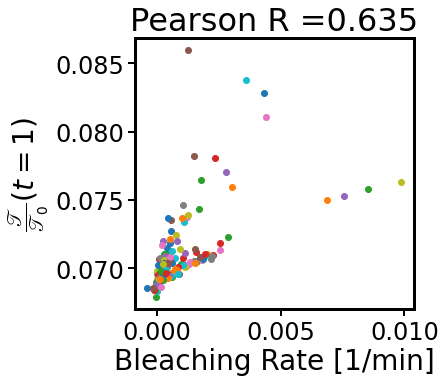

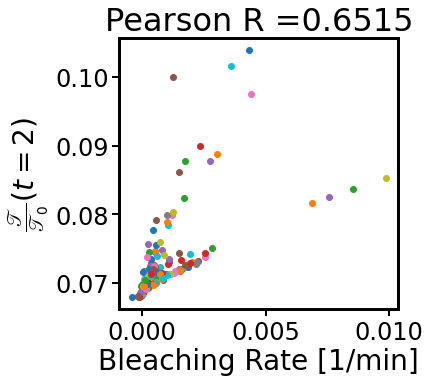

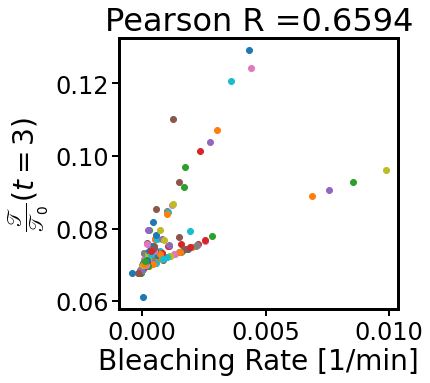

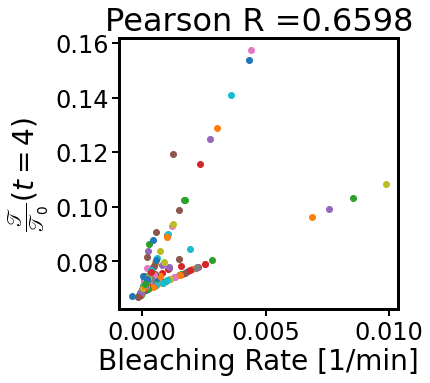

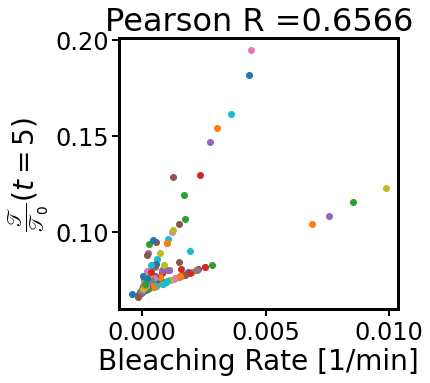

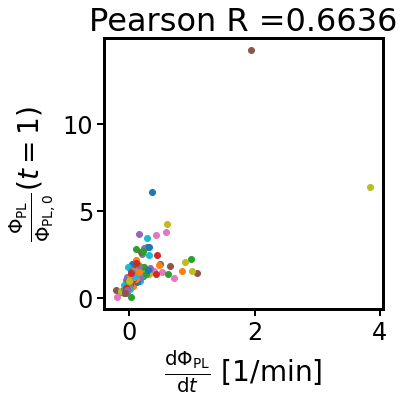

In [26]:
# Look at collinearity of derivatives with early time points

for jj in [1,2,3,4,5]:
    fig, ax = plt.subplots(figsize=(5,5))
    for ii in range(len(rawdata_df)):
        ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr'+str(jj)].iloc[ii],'.')
        #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
    ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Tr'+str(jj)])[0],4)))
    ax.set_xlabel('Bleaching Rate [1/min]')
    ax.set_ylabel('$\\frac{\mathscr{T}}{\mathscr{T}_0}(t=$'+str(jj)+'$)$')
#rawdata_df.head()

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['dPLdt (1/min)'].iloc[ii],rawdata_df['PL1'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['dPLdt (1/min)'],rawdata_df['PL1'])[0],4)))
ax.set_xlabel('$\\frac{\mathrm{d}\Phi_\mathrm{PL}}{\mathrm{d}t}$ [1/min]')
ax.set_ylabel('$\\frac{\Phi_\mathrm{PL}}{\Phi_\mathrm{PL,0}}(t=1)$')

Text(0, 0.5, 'Hydration Rate')

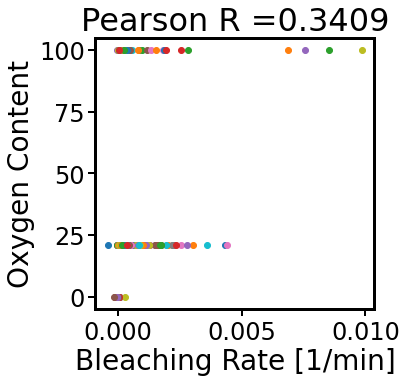

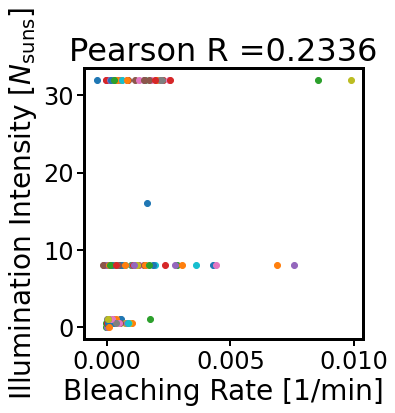

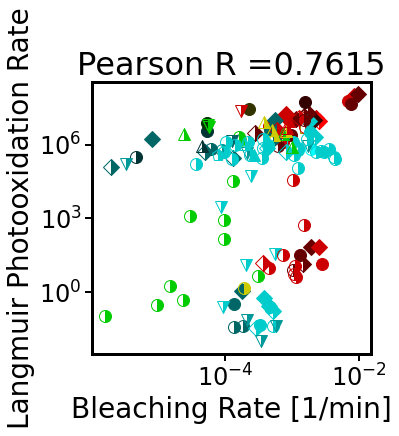

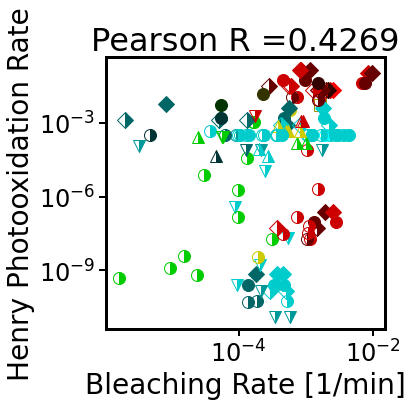

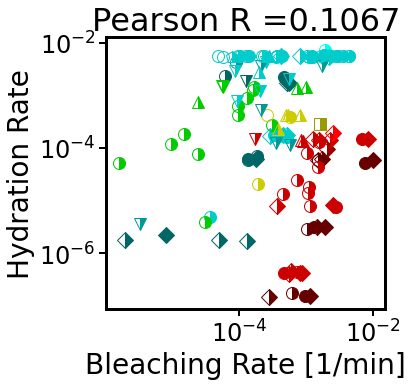

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Oxygen (%)'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Oxygen (%)'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Oxygen Content')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Illum (Nsuns)'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Illum (Nsuns)'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Illumination Intensity [$N_\mathrm{suns}$]')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['PhotoOx_rate'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['PhotoOx_rate'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Langmuir Photooxidation Rate')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['PhotoOx_rate_P'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['PhotoOx_rate_P'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Henry Photooxidation Rate')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Hydration_rate'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Hydration_rate'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Hydration Rate')

# 7. View Coefficient Summaries

For each iteration of the test set loop, we pulled out the values of the coefficients corresponding to each feature; let's look more closely at some statistics to determine how the models look

C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 0.9, 'Feature Weights')

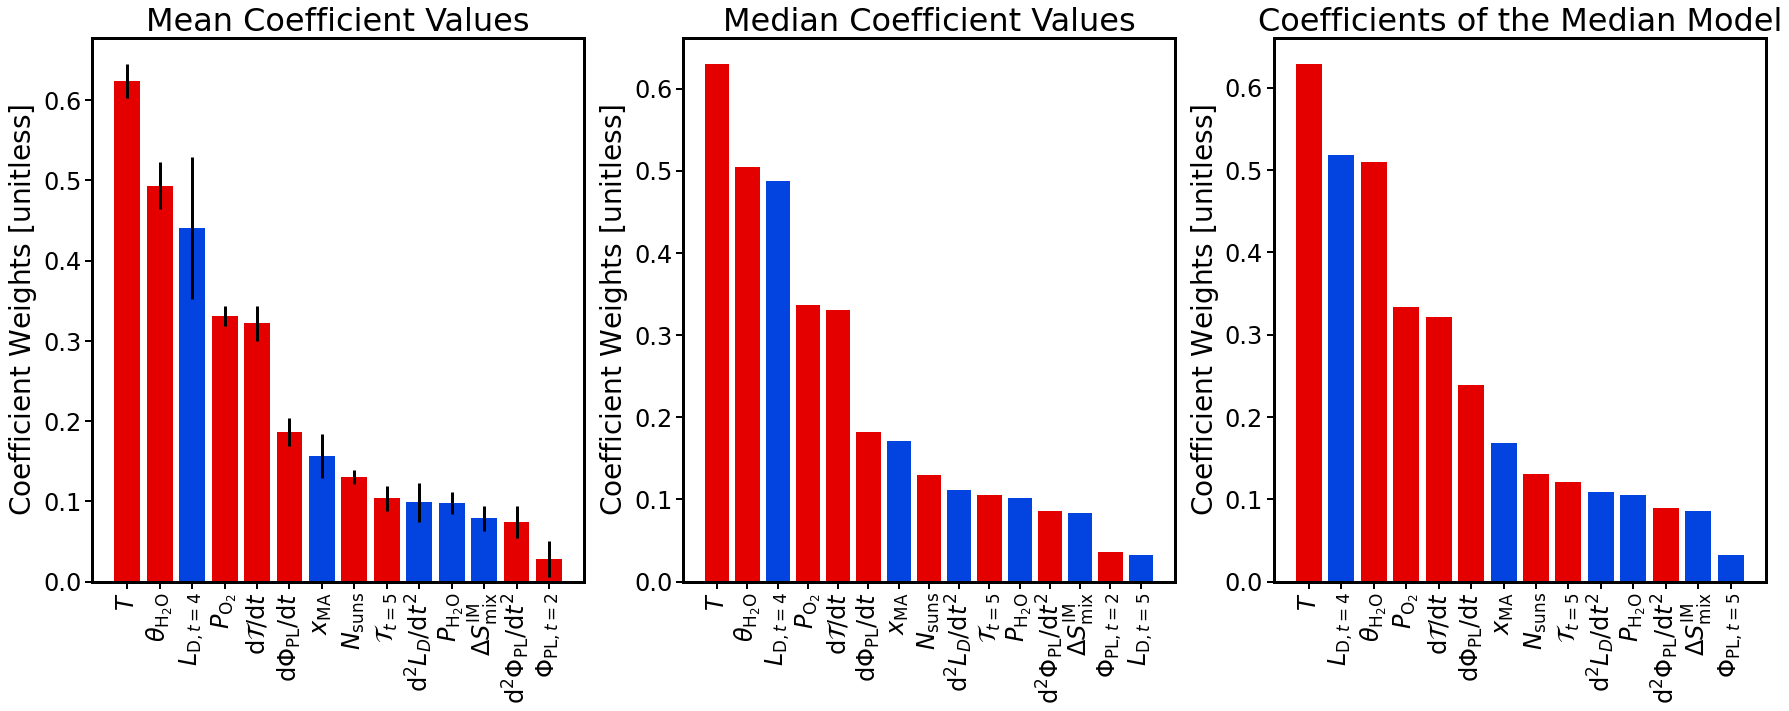

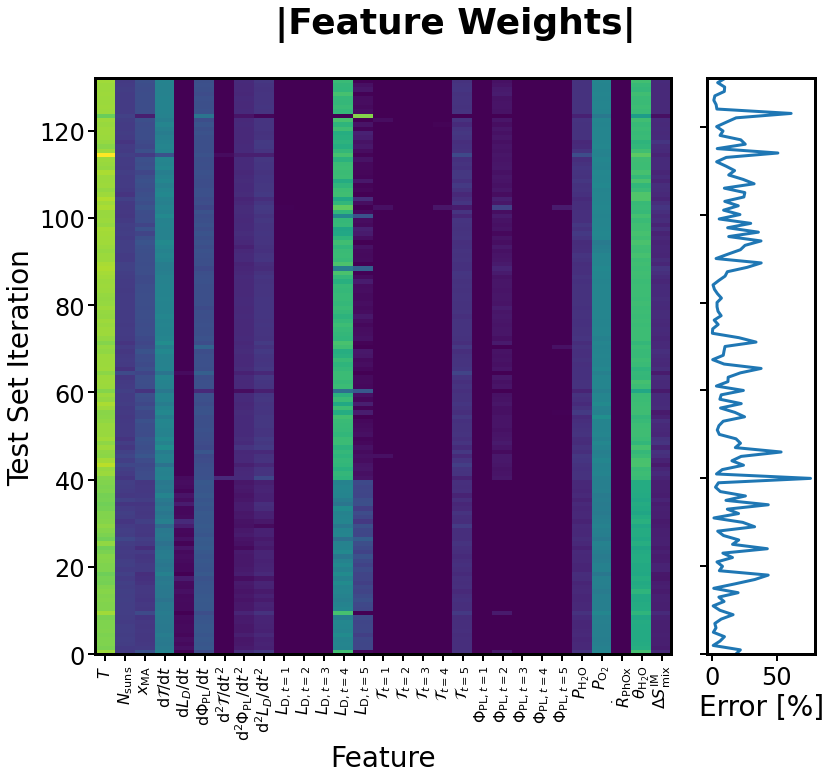

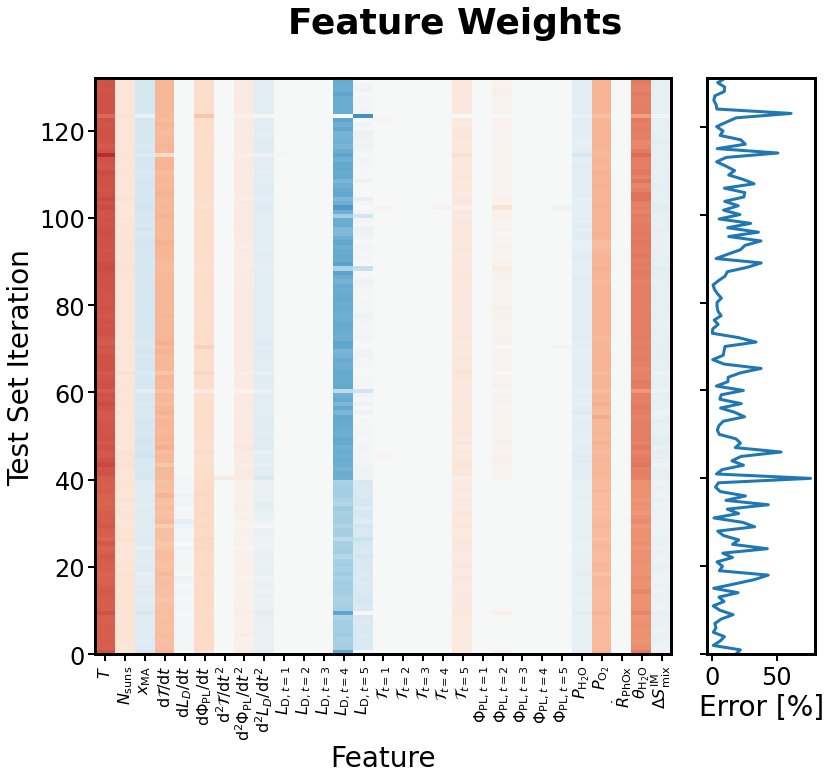

In [44]:
# make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
selected_df = coeffs_df.copy()

for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
    selected_df.iloc[ii] = logic

# make a DF of key statistics on the coefficient values
stats_df = coeffs_df.copy()

# initialize lists of key stats
medians = []
means = []
stds = []

# populate the lists...
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
# ...and add them to the DataFrame 
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds

# plot the median values of the coefficients
#plt.figure(figsize=(10,10))
#plt.bar(stats_df.columns,stats_df.loc['medians'])
#plt.xticks(rotation=90)

# assign bar colors to mean coefficient values
bar_colors_mean = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(means[jj]) == 1:
            bar_colors_mean.append('xkcd:red')
        else:
            bar_colors_mean.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors_mean.append('xkcd:blue')
        else:
            bar_colors_mean.append('xkcd:red')

# assign bar colors to median coefficient values
bar_colors_median = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:red')
        else:
            bar_colors_median.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:blue')
        else:
            bar_colors_median.append('xkcd:red')

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = coeffs # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df['medians'] = np.abs(medians) # add median coefficient values
bars_df['error'] = stds # add standard deviations
bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['means'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

# for making plots look nice:
# dictionary for conversion of ASCII feature labels to TeX-style labels
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }
# define list of nice-looking labels
fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# initialize the figure for comparing coefficients
fig, ax = plt.subplots(1,3,figsize=(30,10))  

# plot the means with error bars represented by the standard deviation
ax[0].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
ax[0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0].set_title('Mean Coefficient Values')

# now re-sort the DF by descending medians
bars_df = bars_df.sort_values(by = 'medians', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_meds_df = bars_df[bars_df['medians'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in nz_meds_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and plot the median coefficient weights
ax[1].bar(nz_meds_df['coeffs'],nz_meds_df['medians'],color=nz_meds_df['colors_median'])
ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
ax[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1].set_title('Median Coefficient Values')

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df.copy()[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and make the plot
ax[2].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2].set_xticklabels(fancy_labels,rotation=90)
ax[2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2].set_title('Coefficients of the Median Model')



# make a figure with all the coefficients in a heat map
fig = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig.add_axes([0,0,0.8,0.8])
ax1.pcolor(np.abs(coeffs_df))
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig.suptitle('|Feature Weights|', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map
fig2 = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_df, cmap = 'RdBu', vmin = -1, vmax = 1)
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')

# 8. Predictions Broken Down by Composition

Make a triptych of parity plots broken down by composition for the model with the median test set error. In these plots we do not distinguish between members of the training and test set.

## CAREFUL -- Note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

Text(2, 6, 'MAE = 14.04%')

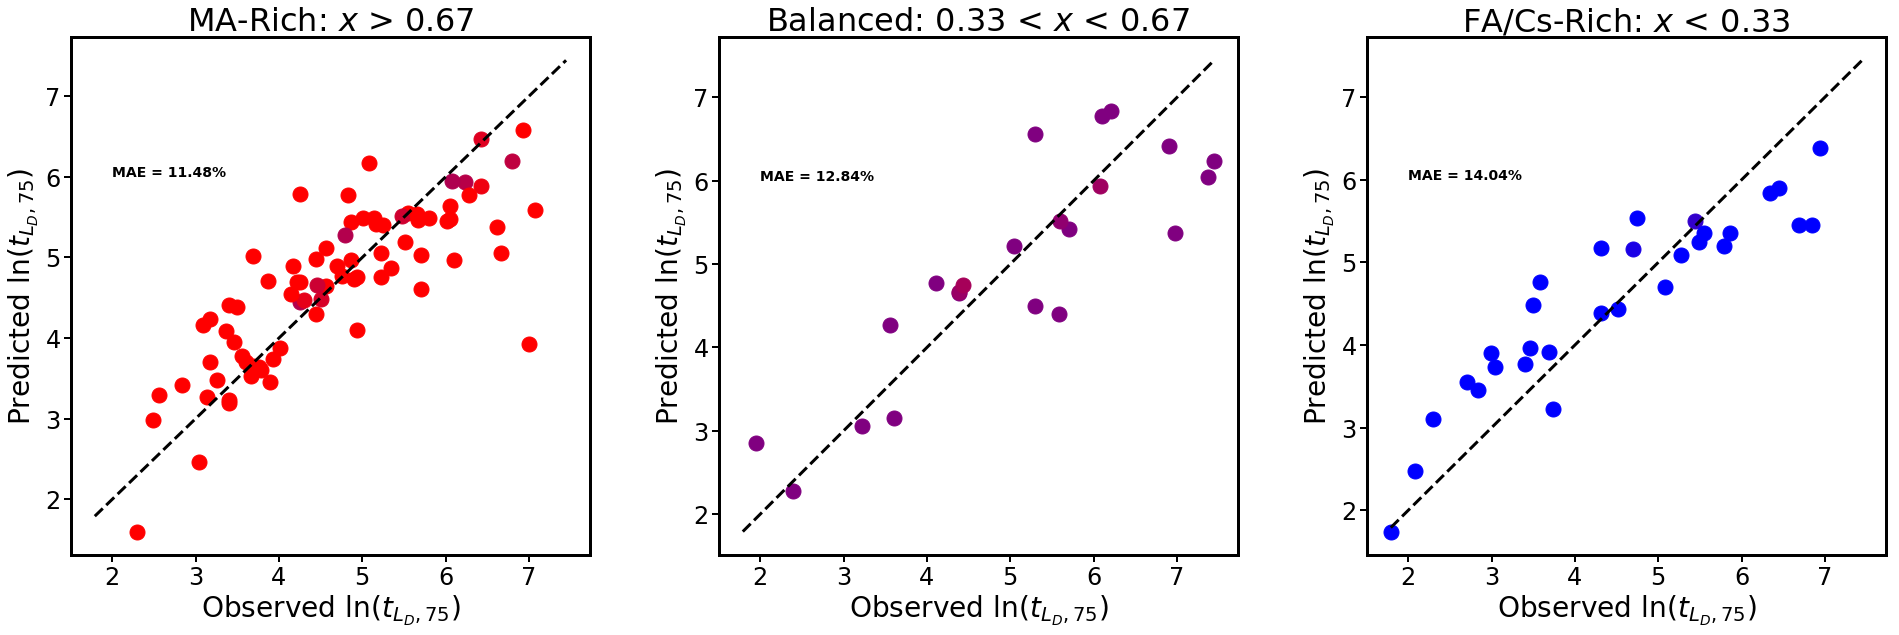

In [27]:
# Make fancy plots of composition

# define initial plot parameters
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# set up the plot axes - this is a more manual way than using plt.subplots(),
# but it ensures that all the axes are square
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge
ax0 = fig.add_axes([0 + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax1 = fig.add_axes([aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax2 = fig.add_axes([2*aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax = [ax0,ax1,ax2]

# where on the plot to put text
if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4

# format specifiers for text
textsize = 14
textweight = 'bold'
    
##### FIRST PANEL: Parity plot for MA-rich compositions

# initialize lists of observed and predicted values for MA-rich samples
MA_rich_act = []
MA_rich_pred = []

# loop over training set first
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_train.loc[idx])
        MA_rich_pred.append(ytpred[ii])
        ax[0].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# make axis labels according to the appropriate response variable
if response == 'tLD75 (min)':
    ax[0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[0].set_title('MA-Rich: $x$ > 0.67')

# now plot the test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_whold.loc[idx])
        MA_rich_pred.append(ypred[ii])
        ax[0].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# convert lists to arrays to faciliate stats calcs
MA_rich_act = np.array(MA_rich_act) 
MA_rich_pred = np.array(MA_rich_pred) 
        
# stats calcs
MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100

# note the error on the plot
ax[0].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_rich_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

##### SECOND PANEL: Parity plot for balanced compositions

# initialize lists of observed and predicted 
MA_bal_act = []
MA_bal_pred = []

# loop over training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_train.loc[idx])
        MA_bal_pred.append(ytpred[ii])
        ax[1].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# make axis labels according to the appropriate response variable
if response == 'tLD75 (min)':
    ax[1].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[1].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[1].set_title('Balanced: 0.33 < $x$ < 0.67')

# loop over test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_whold.loc[idx])
        MA_bal_pred.append(ypred[ii])
        ax[1].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# convert lists to arrays to faciliate stats calcs
MA_bal_act = np.array(MA_bal_act) 
MA_bal_pred = np.array(MA_bal_pred) 
        
# stats calcs        
MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100

# put error on plot
ax[1].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_bal_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

##### THIRD PANEL: Parity plot for FACS-rich compositions

# initalize lists
MA_lean_act = []
MA_lean_pred = []

# training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_train.loc[idx])
        MA_lean_pred.append(ytpred[ii])
        ax[2].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# set axis labels and title
if response == 'tLD75 (min)':
    ax[2].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[2].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[2].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[2].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[2].set_title('FA/Cs-Rich: $x$ < 0.33')

# test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_whold.loc[idx])
        MA_lean_pred.append(ypred[ii])
        ax[2].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# lists -> arrays
MA_lean_act = np.array(MA_lean_act) 
MA_lean_pred = np.array(MA_lean_pred) 
        
# calculate and plot error
MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
ax[2].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_lean_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

# Print figure title and panel labels if desired
#fig.suptitle('Early-Time Features', x=0.5, y=1, fontsize=48, weight='bold')
#fig.text(0,ax_size,'a',fontsize=36,weight='bold')
#fig.text(aspect_x,ax_size,'b',fontsize=36,weight='bold')
#fig.text(2*aspect_x,ax_size,'c',fontsize=36,weight='bold')

# 9. Predictions Broken Down by Environmental Conditions

Make a four-panel figure with a) coefficient weights of the median model, b) parity plot of the median model, c) test set error distribution, and d) symbol legend

## CAREFUL -- As in block (8), note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

Text(0.5, 0.45, 'c')

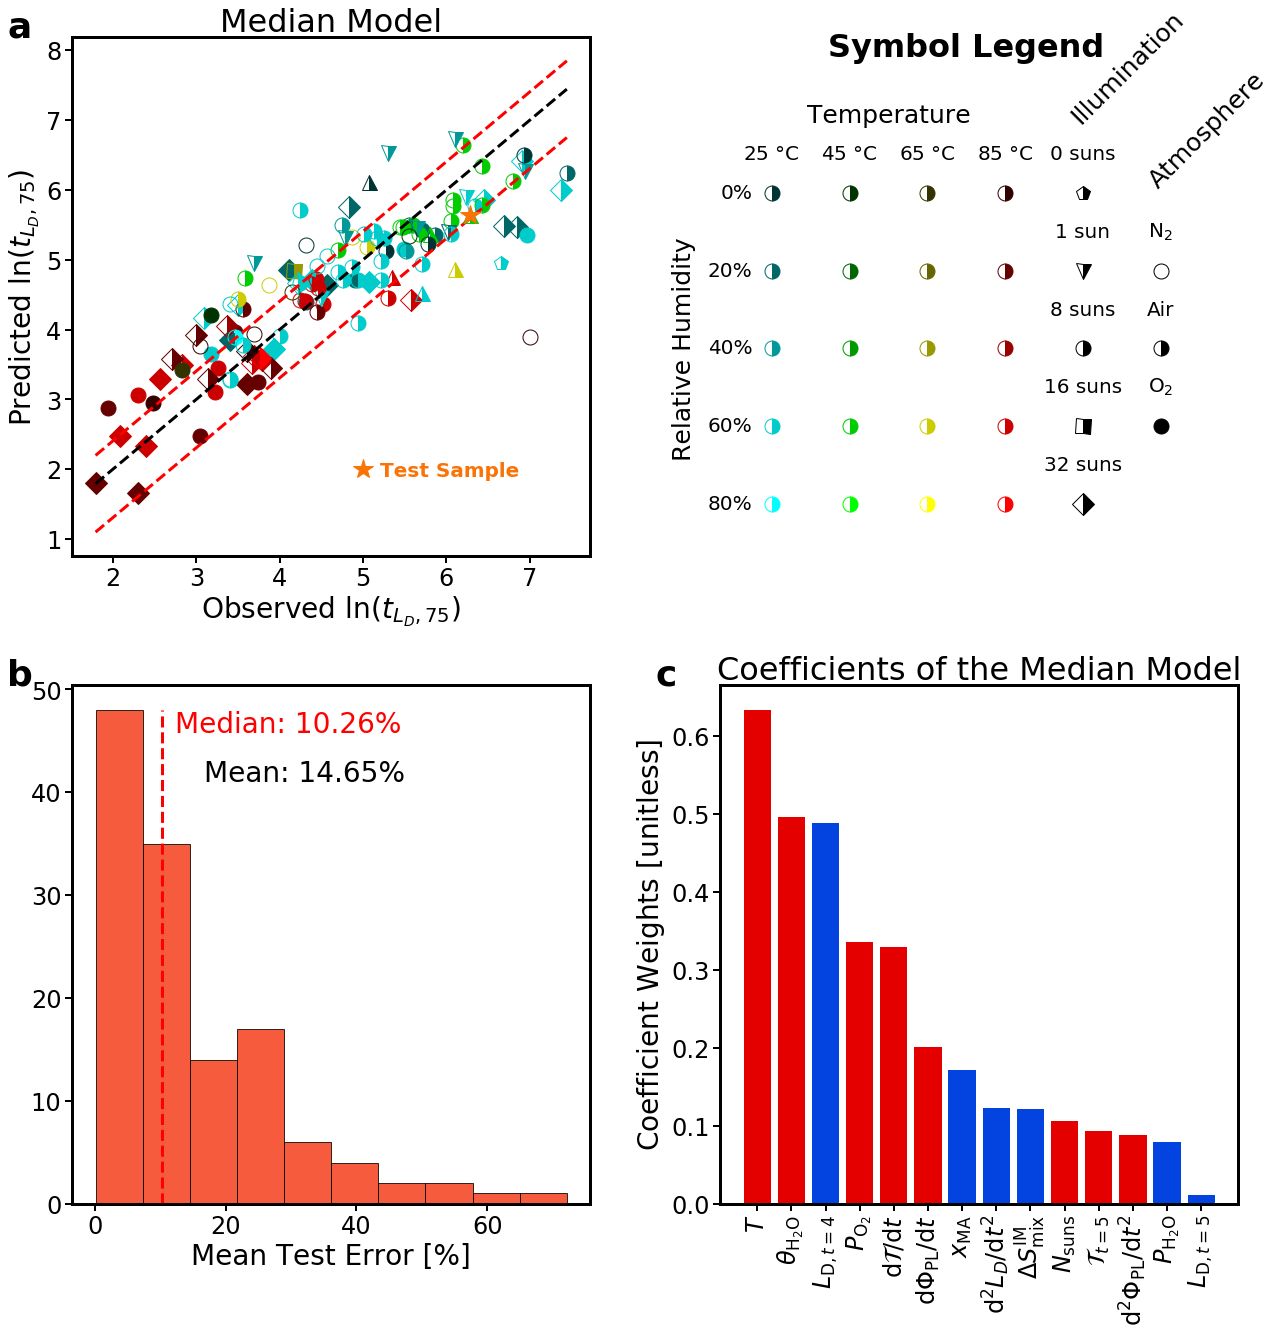

In [19]:
# Make fancy plots of test set error 

# Set up the subplot parameters - again we want square panels not square subplots, so we do things manually
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_x):
    row_panel_list = []
    for jj in range(n_plots_y):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list)    

##### TOP LEFT: parity plot of median model
actual_all = []
preds_all = []

# plot training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot perfect prediction line and +/-50% error bounds (latter good for DOE presentations, bad for publications)
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
ax[0][0].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
ax[0][0].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

# set appropriate axis labels and title
if response == 'tLD75 (min)':
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0][0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0][0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[0][0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    ax[0][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    # test sample in orange
    ax[0][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

# plot legend for test sample
if response == 'tLD75 (min)':
    ax[0][0].plot(5,2,marker='*',markersize=20,color='xkcd:orange')
    ax[0][0].text(5.2,1.98,'Test Sample',fontsize=20,weight='bold',color='xkcd:orange',va='center')
  
# calculate error metrics
actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# set text position for the approporiate response variable
if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    
##### TOP RIGHT: symbol legend
ax[0][1].axis('off') # no bounding box
ax[0][1].set_xlim([0,10]) # set grid for plotting symbols on
ax[0][1].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[0][1].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot temp legends
ax[0][1].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[0][1].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot illumination legends
ax[0][1].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot O2 legends
ax[0][1].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[0][1].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')


##### BOTTOM LEFT: test set error distribution
ax[1][0].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[1][0].set_xlabel('Mean Test Error [%]')
ax[1][0].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
ax[1][0].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
              'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
ax[1][0].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
              'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

##### BOTTOM RIGHT: coefficients of the median model

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and make the plot
ax[1][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[1][1].set_xticklabels(fancy_labels,rotation=90)
ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1][1].set_title('Coefficients of the Median Model')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
fig.text(0,0.95,'a',fontsize=36,weight='bold')
fig.text(0,0.45,'b',fontsize=36,weight='bold')
fig.text(0.5,0.45,'c',fontsize=36,weight='bold')

### Uncomment the linest below to see corners of the figure
#fig.text(0,0,'(0,0)')
#fig.text(1,0,'(1,0)')
#fig.text(0,1,'(0,1)')
#fig.text(1,1,'(1,1)')

# 10. Make a Big Figure 4

Plot the most sophisticated physics-inspired models, using leave-one-out testing in the top row and normal operating conditions testing in the bottom row.

KeyError: "['PL3', 'ddTr0', 'ddLD0', 'PL2', 'Tr3', 'dTrdt', 'ddPL0', 'Tr5', 'PL5', 'Ld1', 'PhotoOx_rate', 'dPLdt', 'Tr1', 'Ld4', 'Ld5', 'Tr2', 'Ld2', 'PL1', 'dLDdt', 'Tr4', 'PL4', 'delS_mix', 'Ld3'] not in index"

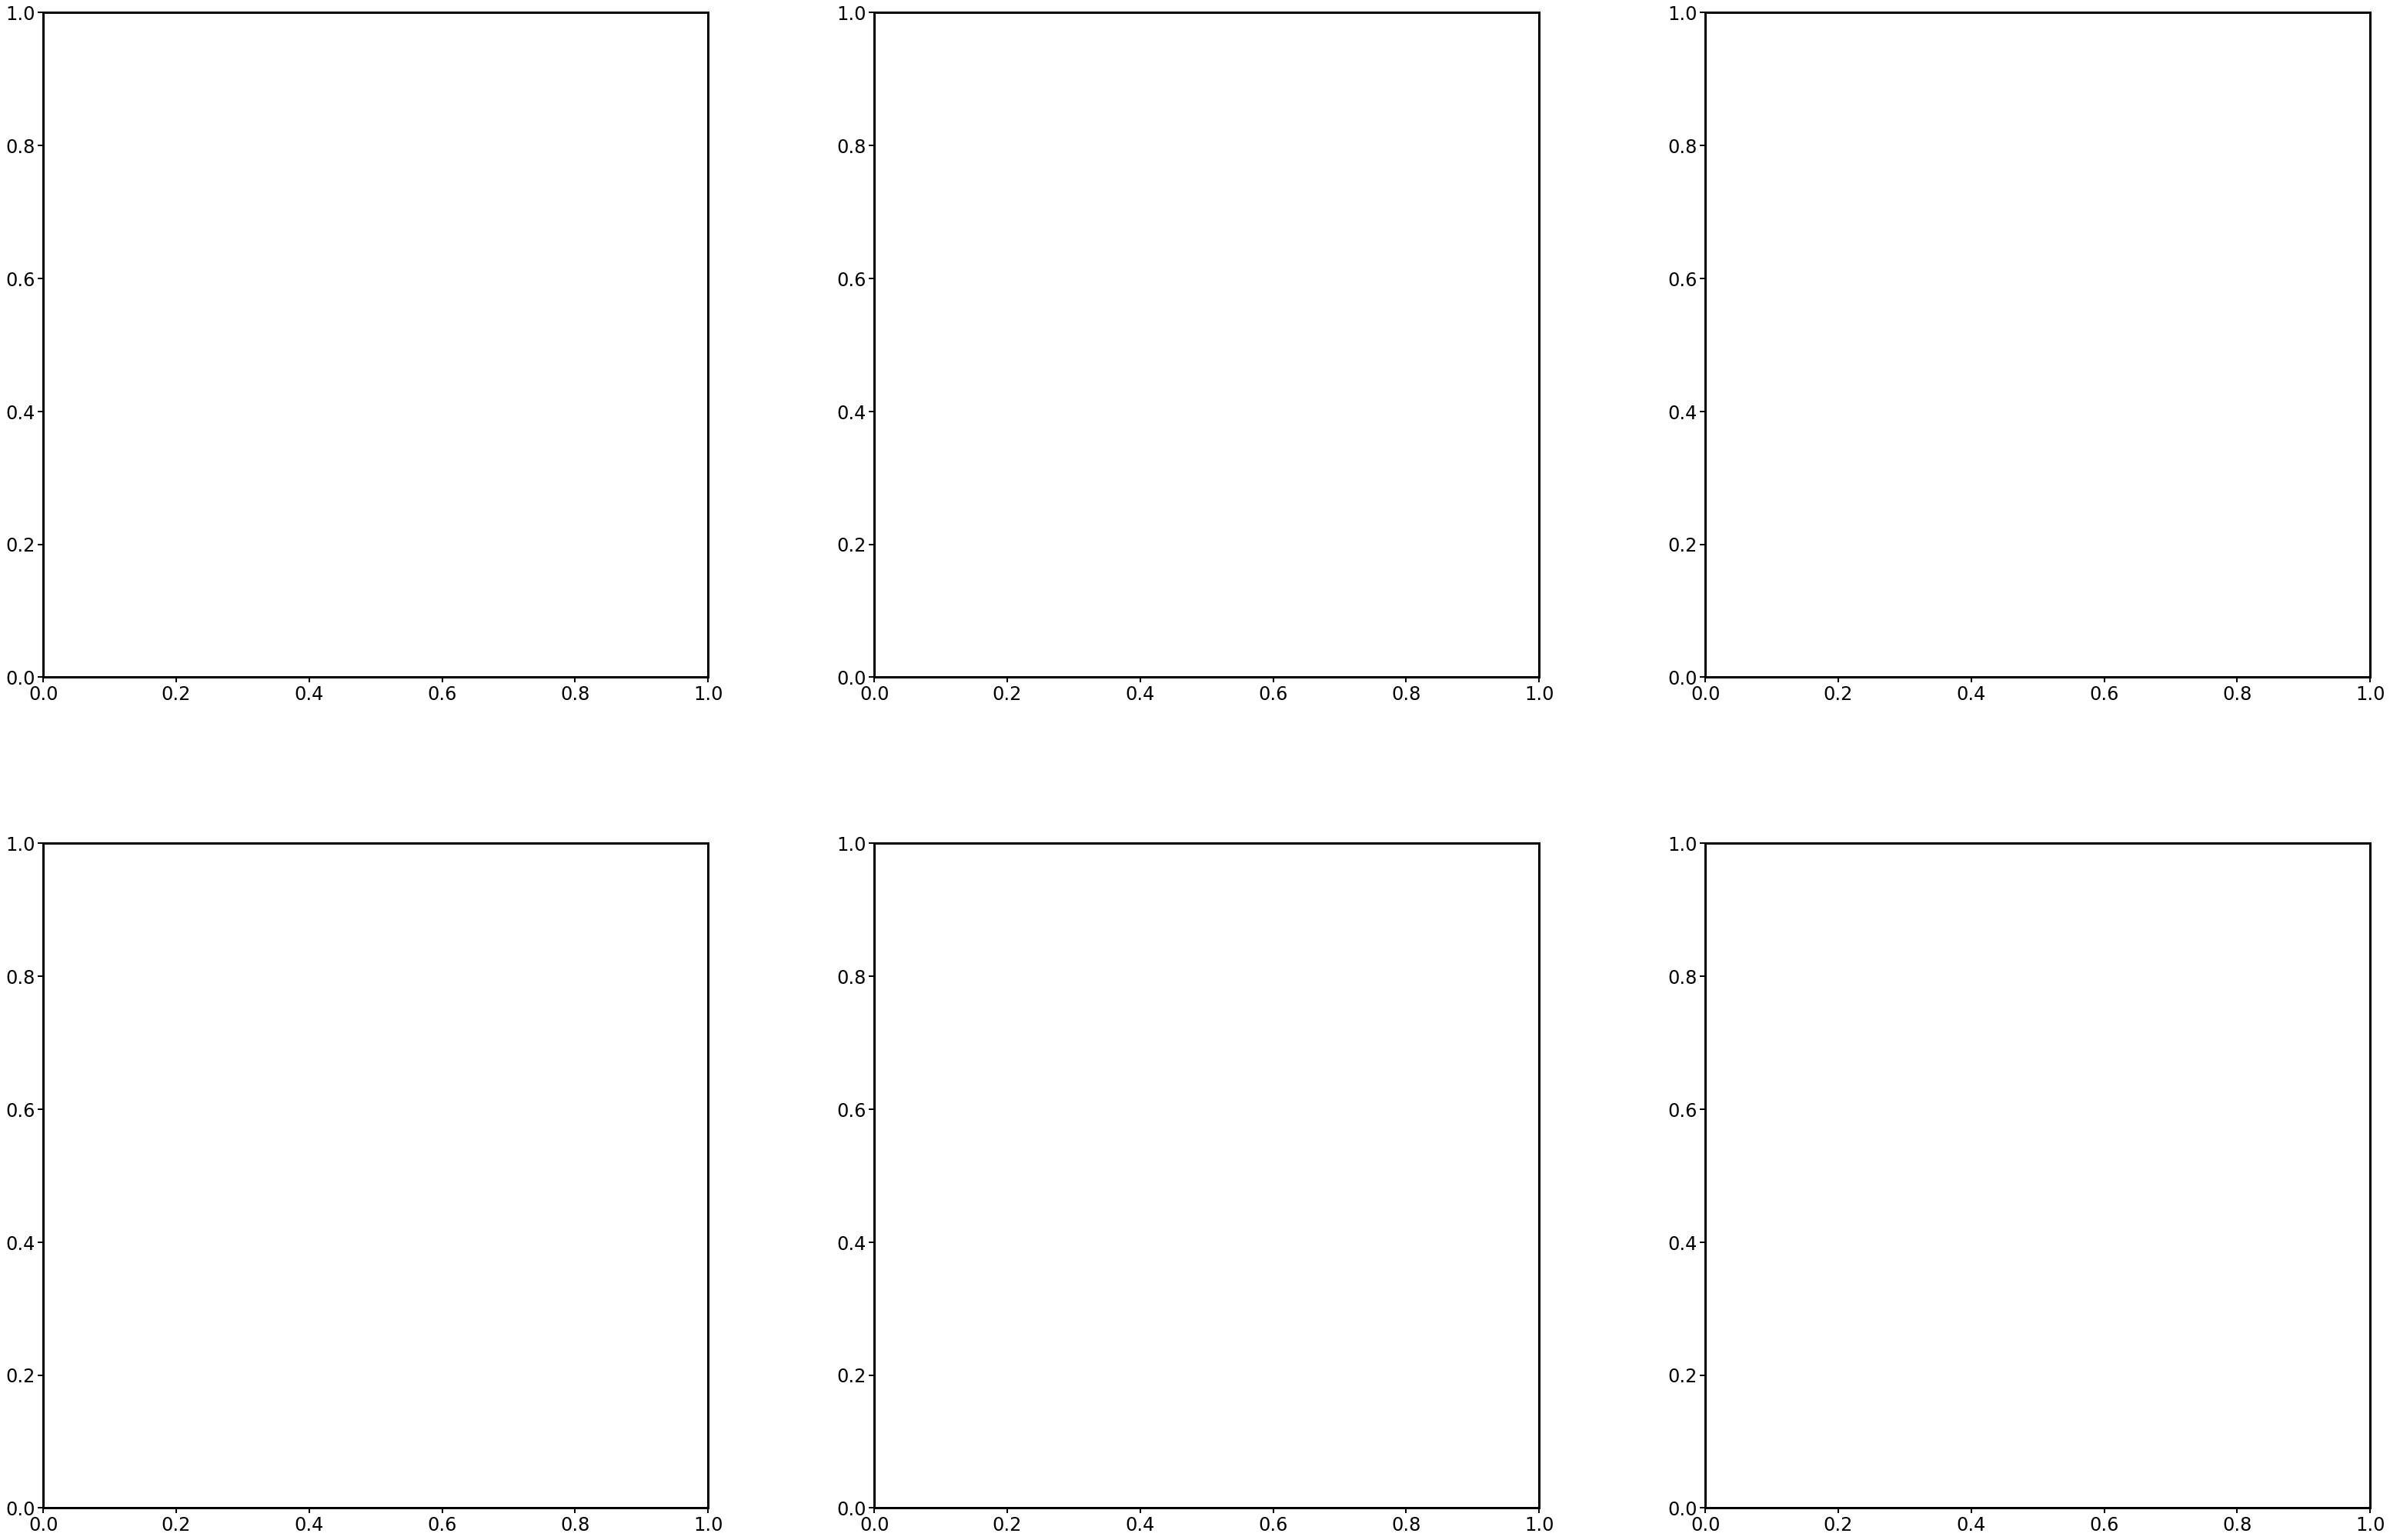

In [132]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48

##### TOP PANEL: parity plot for model with leave-one-out testing

# train the model
# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = n_trials-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E',
                 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]
    
    fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }
    
    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model',fontsize=title_size)
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=axis_lab_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

###### BOTTOM ROW: plot the model trained on accelerated testing conditions tested on normal operating conditions

# find indices in the mother dataframe corresponding to 1 sun test conditions,
# which we definte  as "normal operating conditions"
NOP_indices = rawdata_df[rawdata_df['Illum (Nsuns)'] == 1].index

# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = 1
#n_trials=5

# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e9)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y) - len(NOP_indices)- 1

# initialize error metrics for test set
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE = np.zeros(n_trials) # mean absolute error

# for the whole dataset
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# initialize a dataframe to keep track of model coefficients
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)

kk = 0

# Recalculate NOP indices based on which runs make it through the dropna() filter
NOP_indices = coded_df.loc[NOP_indices].dropna().index

# And do test-train split
X_whold = X.loc[NOP_indices].copy()
y_whold = Y.loc[NOP_indices].copy()
X_train = X.drop(index=NOP_indices).copy()
y_train = Y.drop(index=NOP_indices).copy()

# standardize the data according to the mean and variance of the training dataset
z_means = []
z_stds = []

for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    print(col_mean)
    z_means.append(col_mean)
    z_stds.append(col_std)
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold


# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
#ypred=final_model.predict(np.array(X_whold).reshape(1,-1)) # when test set is a single sample
ypred=final_model.predict(np.array(X_whold)) # when test set n > 1
ytpred=final_model.predict(X_train)

# calculate error metrics on test set
#RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
#R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold), ypred))
R2[kk] = metrics.r2_score(np.array(y_whold), ypred)
MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
MAE[kk] = np.mean(np.abs(y_whold-ypred))

# put the whole dataset back together (note that this will create arrays, not DFs)
y_net = np.concatenate([y_train,y_whold])
y_pred_net = np.concatenate([ytpred,ypred])

# calculate error metrics on entire set
R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

# calculate error metrics on training set
R2_train[kk] = metrics.r2_score(y_train, ytpred)
MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

# plot training data with markers corresponding to environmental + compositional conditions

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)
    ax[1][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=30,color='xkcd:orange')                

# save the model coefficients
coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

coeffs_df.rename(columns = new_dict, inplace = True)
try:
    coeffs_df.rename(columns = second_order_dict, inplace = True)
except:
    pass

coeffs = coeffs_df.columns

avgs = np.mean(coeffs_df)
error = np.std(coeffs_df)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax[1][1].bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[1][1].set_xticklabels(labels=fancy_labels,rotation=90,fontsize=axis_lab_size)

ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
ax[1][1].set_title('Model Coefficients',fontsize=title_size)

# plot the symbol legend
ax[1][2].axis('off') # no bounding box
ax[1][2].set_xlim([0,10]) # set grid for plotting symbols on
ax[1][2].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[1][2].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[1][2].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[1][2].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[1][2].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[1][2].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[1][2].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# row titles
fig.text(-0.02, 3/4, 'Leave-One-Out Testing', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/4, 'Normal Op. Cond. Testing', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,1/2-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,1/2-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,1/2-v_offset,'f',fontsize=60,weight='bold')

for i in range(2):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

In [48]:
MAE_pct

array([13.25078808])

# 11. Make a Large Figure 2 for the Paper

Here we want a high-level comparison of the predictions made by the models with and without the environmental features, linear features only.

C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
34


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.1}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
7


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


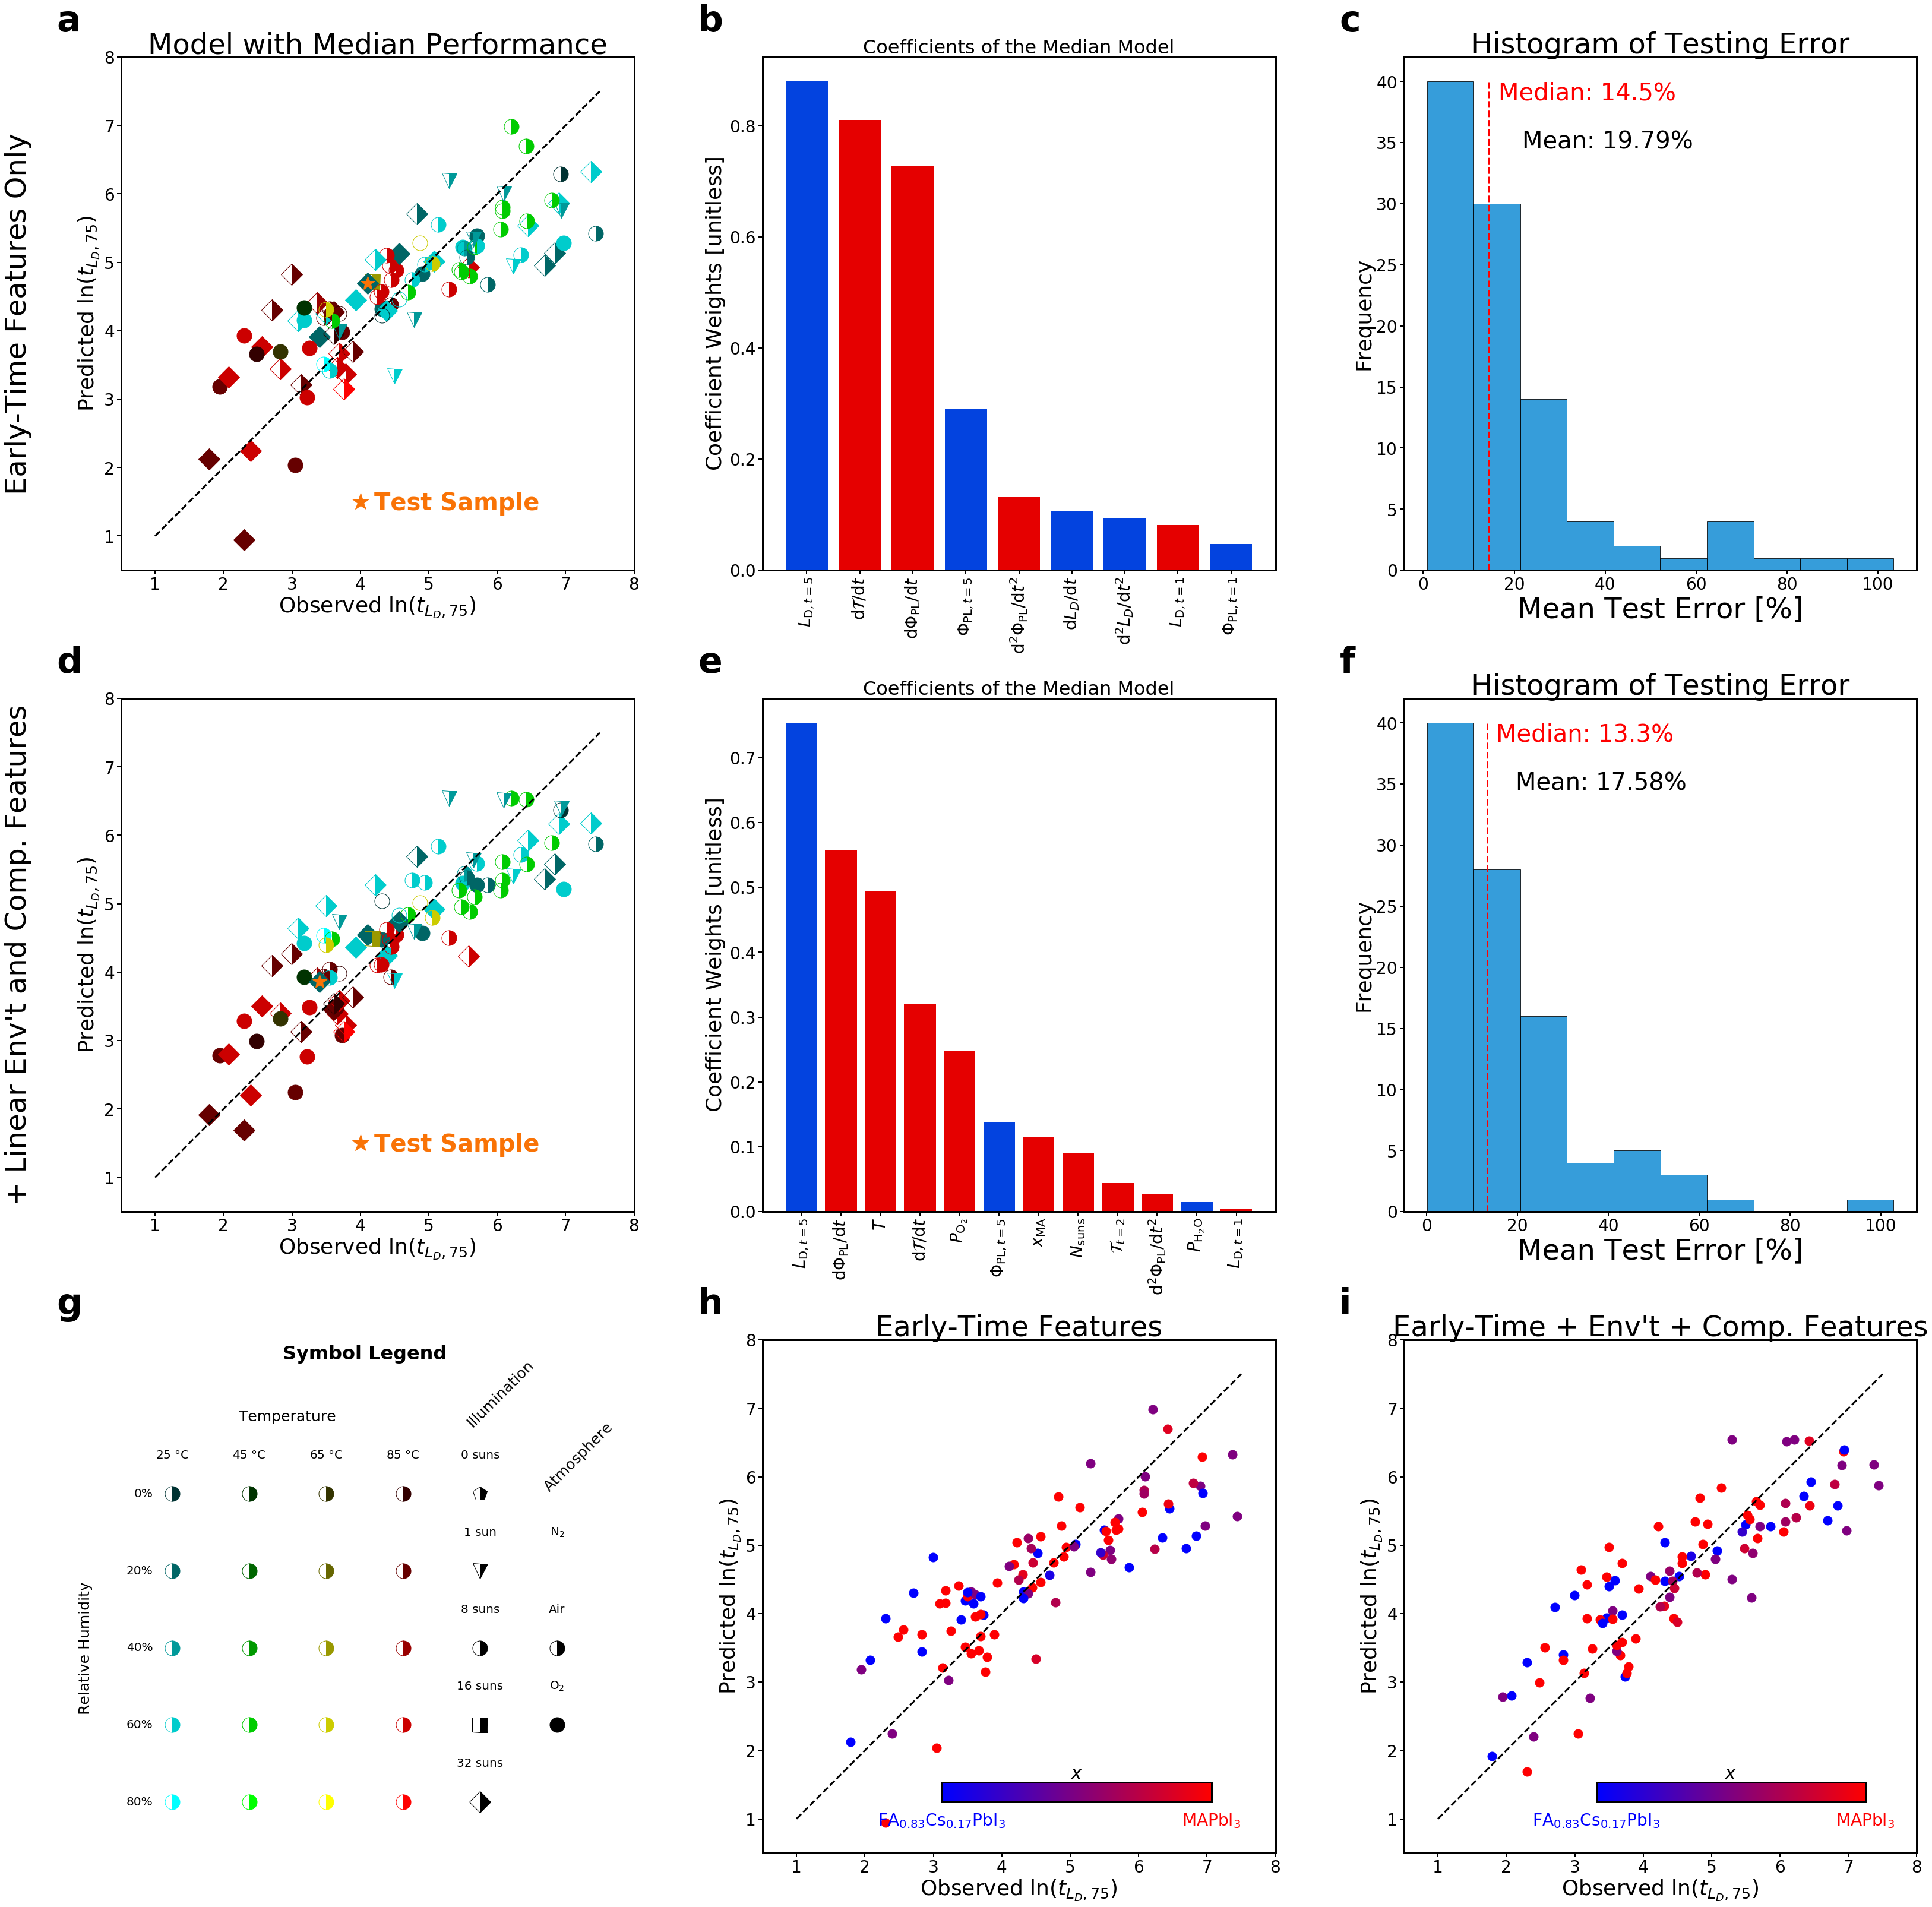

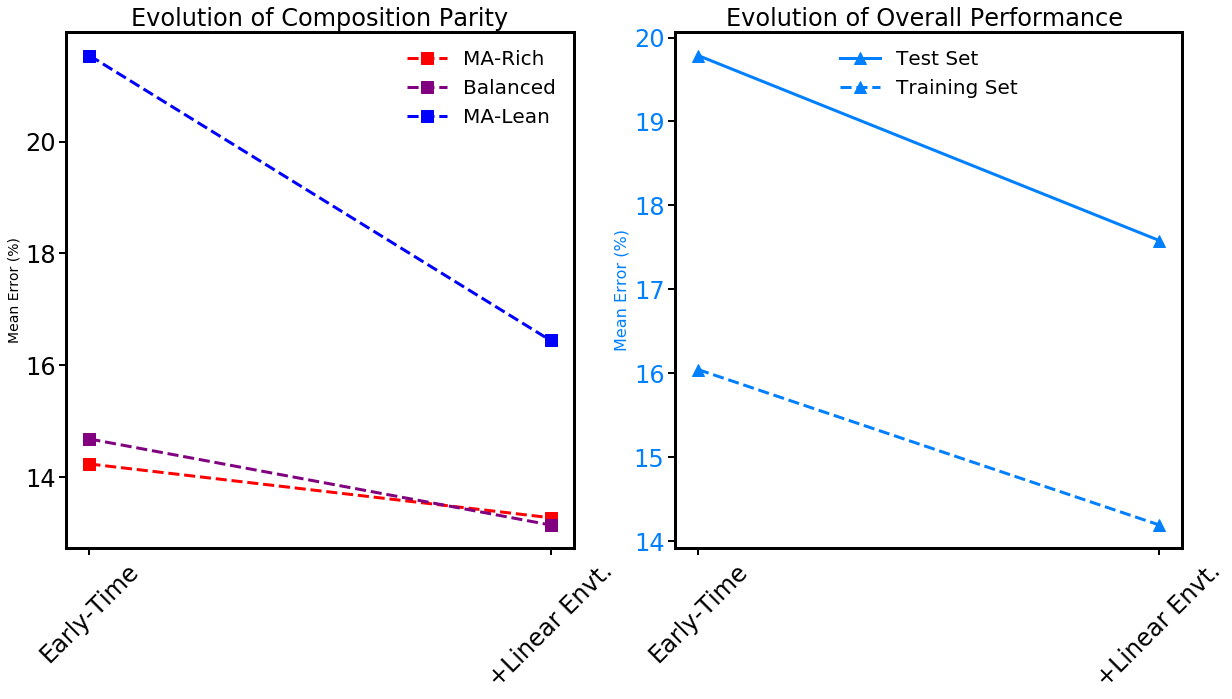

In [49]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48
    
# set up the model

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y)-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5']
                ,
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E']
                ,
                #['dTrdt','dLDdt','dPLdt',
                # 'ddTr0','ddLD0','ddPL0',
                # 'Ld1','Ld2','Ld3','Ld4','Ld5',
                # 'Tr1','Tr2','Tr3','Tr4','Tr5',
                # 'PL1','PL2','PL3','PL4','PL5',
                # 'A','P_H2O','P_O2','D','E',
                # 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    # Plot the median model, indexed by composition, in the left panel
    # ax[ii][0].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_train.loc[idx],ytpred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[2][j+1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # label the plot
    ax[2][j+1].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[2][j+1].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    if j == 0 and i != 2:
        ax[0][j].set_title('Model with Median Performance',fontsize=title_size)
    
    # set axis limits
    ax[2][j+1].set_xlim([0.5,8])
    ax[2][j+1].set_ylim([0.5,8])

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_whold[idx],ypred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)
    
    # calculate the error metrics on the MA-rich data
    MA_rich_act = []
    MA_rich_pred = []
    
    # scan over training set...
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_train.loc[idx])
            MA_rich_pred.append(ytpred[ii])

    # ...and over test set
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_whold.loc[idx])
            MA_rich_pred.append(ypred[ii])
    
    # calculate error and append to list
    MA_rich_act = np.array(MA_rich_act) 
    MA_rich_pred = np.array(MA_rich_pred) 
    MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
    MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100
    performance_list.append(np.mean(MA_rich_MAE_pct))
    
    # do the same for the balanced MA 
    MA_bal_act = []
    MA_bal_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_train.loc[idx])
            MA_bal_pred.append(ytpred[ii])
            
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_whold.loc[idx])
            MA_bal_pred.append(ypred[ii])
   
    MA_bal_act = np.array(MA_bal_act) 
    MA_bal_pred = np.array(MA_bal_pred) 
    MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
    MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
    performance_list.append(np.mean(MA_bal_MAE_pct))
    
    # and the FA/Cs rich compositions
    MA_lean_act = []
    MA_lean_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_train.loc[idx])
            MA_lean_pred.append(ytpred[ii])

    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_whold.loc[idx])
            MA_lean_pred.append(ypred[ii])
            
    MA_lean_act = np.array(MA_lean_act) 
    MA_lean_pred = np.array(MA_lean_pred) 
    MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
    MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
    performance_list.append(np.mean(MA_lean_MAE_pct))
    
    # append the composition-subdivided R2 scores too
    performance_list.append(MA_rich_R2)
    performance_list.append(MA_bal_R2)
    performance_list.append(MA_lean_R2)
    
    # append the list of error and performance metrics to the meta-list
    performance_metalist.append(performance_list)
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model')
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=title_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    
    # set title depending on iteration



    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

        
ax[2][1].set_title('Early-Time Features',fontsize=title_size)
ax[2][2].set_title('Early-Time + Env\'t + Comp. Features',fontsize=title_size)

# plot the symbol legend
ax[2][0].axis('off') # no bounding box
ax[2][0].set_xlim([0,10]) # set grid for plotting symbols on
ax[2][0].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[2][0].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[2][0].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[2][0].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[2][0].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[2][0].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[2][0].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')

##### FINAL FIGURE ANNOTATIONS

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,2/3-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,2/3-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,2/3-v_offset,'f',fontsize=60,weight='bold')
fig.text(0,1/3-v_offset,'g',fontsize=60,weight='bold')
fig.text(1/3,1/3-v_offset,'h',fontsize=60,weight='bold')
fig.text(2/3,1/3-v_offset,'i',fontsize=60,weight='bold')

# add colorbars to composition color plots

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)



####### NEW FIGURE: #######


# Make some plots of model performance statistics
echelons = ['Early-Time','+Linear Envt.','+Physics-Inspired']
performance_DF = pd.DataFrame(performance_metalist,columns=performance_metrics,index=echelons[:2])

fig2, ax2 = plt.subplots(1,2,figsize=(20,9.5))

# left panel: error broken down by composition
ax2[0].plot(performance_DF.index,performance_DF['MA-Rich Error (%)'],'s--',color=(1,0,0),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['Balanced Error (%)'],'s--',color=(0.5,0,0.5),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['FACs-Rich Error (%)'],'s--',color=(0,0,1),markersize=12)
ax2[0].set_ylabel('Mean Error (%)',fontsize=14)
ax2[0].tick_params(axis='x', rotation=45)
ax2[0].set_title('Evolution of Composition Parity',fontsize=24)
ax2[0].legend(['MA-Rich','Balanced','MA-Lean'],fontsize=20,loc='upper right',frameon=False)

# right panel: test and training set error
ax2[1].plot(performance_DF.index,performance_DF['Mean Test Set Error (%)'],'^-',color=(0,0.5,1),markersize=12)
ax2[1].plot(performance_DF.index,performance_DF['Mean Training Set Error (%)'],'^--',color=(0,0.5,1),markersize=12)
ax2[1].set_ylabel('Mean Error (%)',color=(0,0.5,1),fontsize=16)
ax2[1].tick_params(axis='y', labelcolor=(0,0.5,1))
ax2[1].tick_params(axis='x', rotation=45)
ax2[1].set_title('Evolution of Overall Performance ',fontsize=24)
ax2[1].legend(['Test Set','Training Set'],fontsize=20,loc='upper center',frameon=False)
# also training set R2
#ax_21 = ax2[1].twinx()
#ax_21.plot(performance_DF.index,performance_DF['Mean Training Set R2'],'^--',color=(1,0,0),markersize=12)
#ax_21.set_ylabel('Training Set $R^2$',color=(1,0,0))
#ax_21.tick_params(axis='y', labelcolor=(1,0,0))


Text(-0.02, 0.5, "+ Linear Env't and Comp. Features")

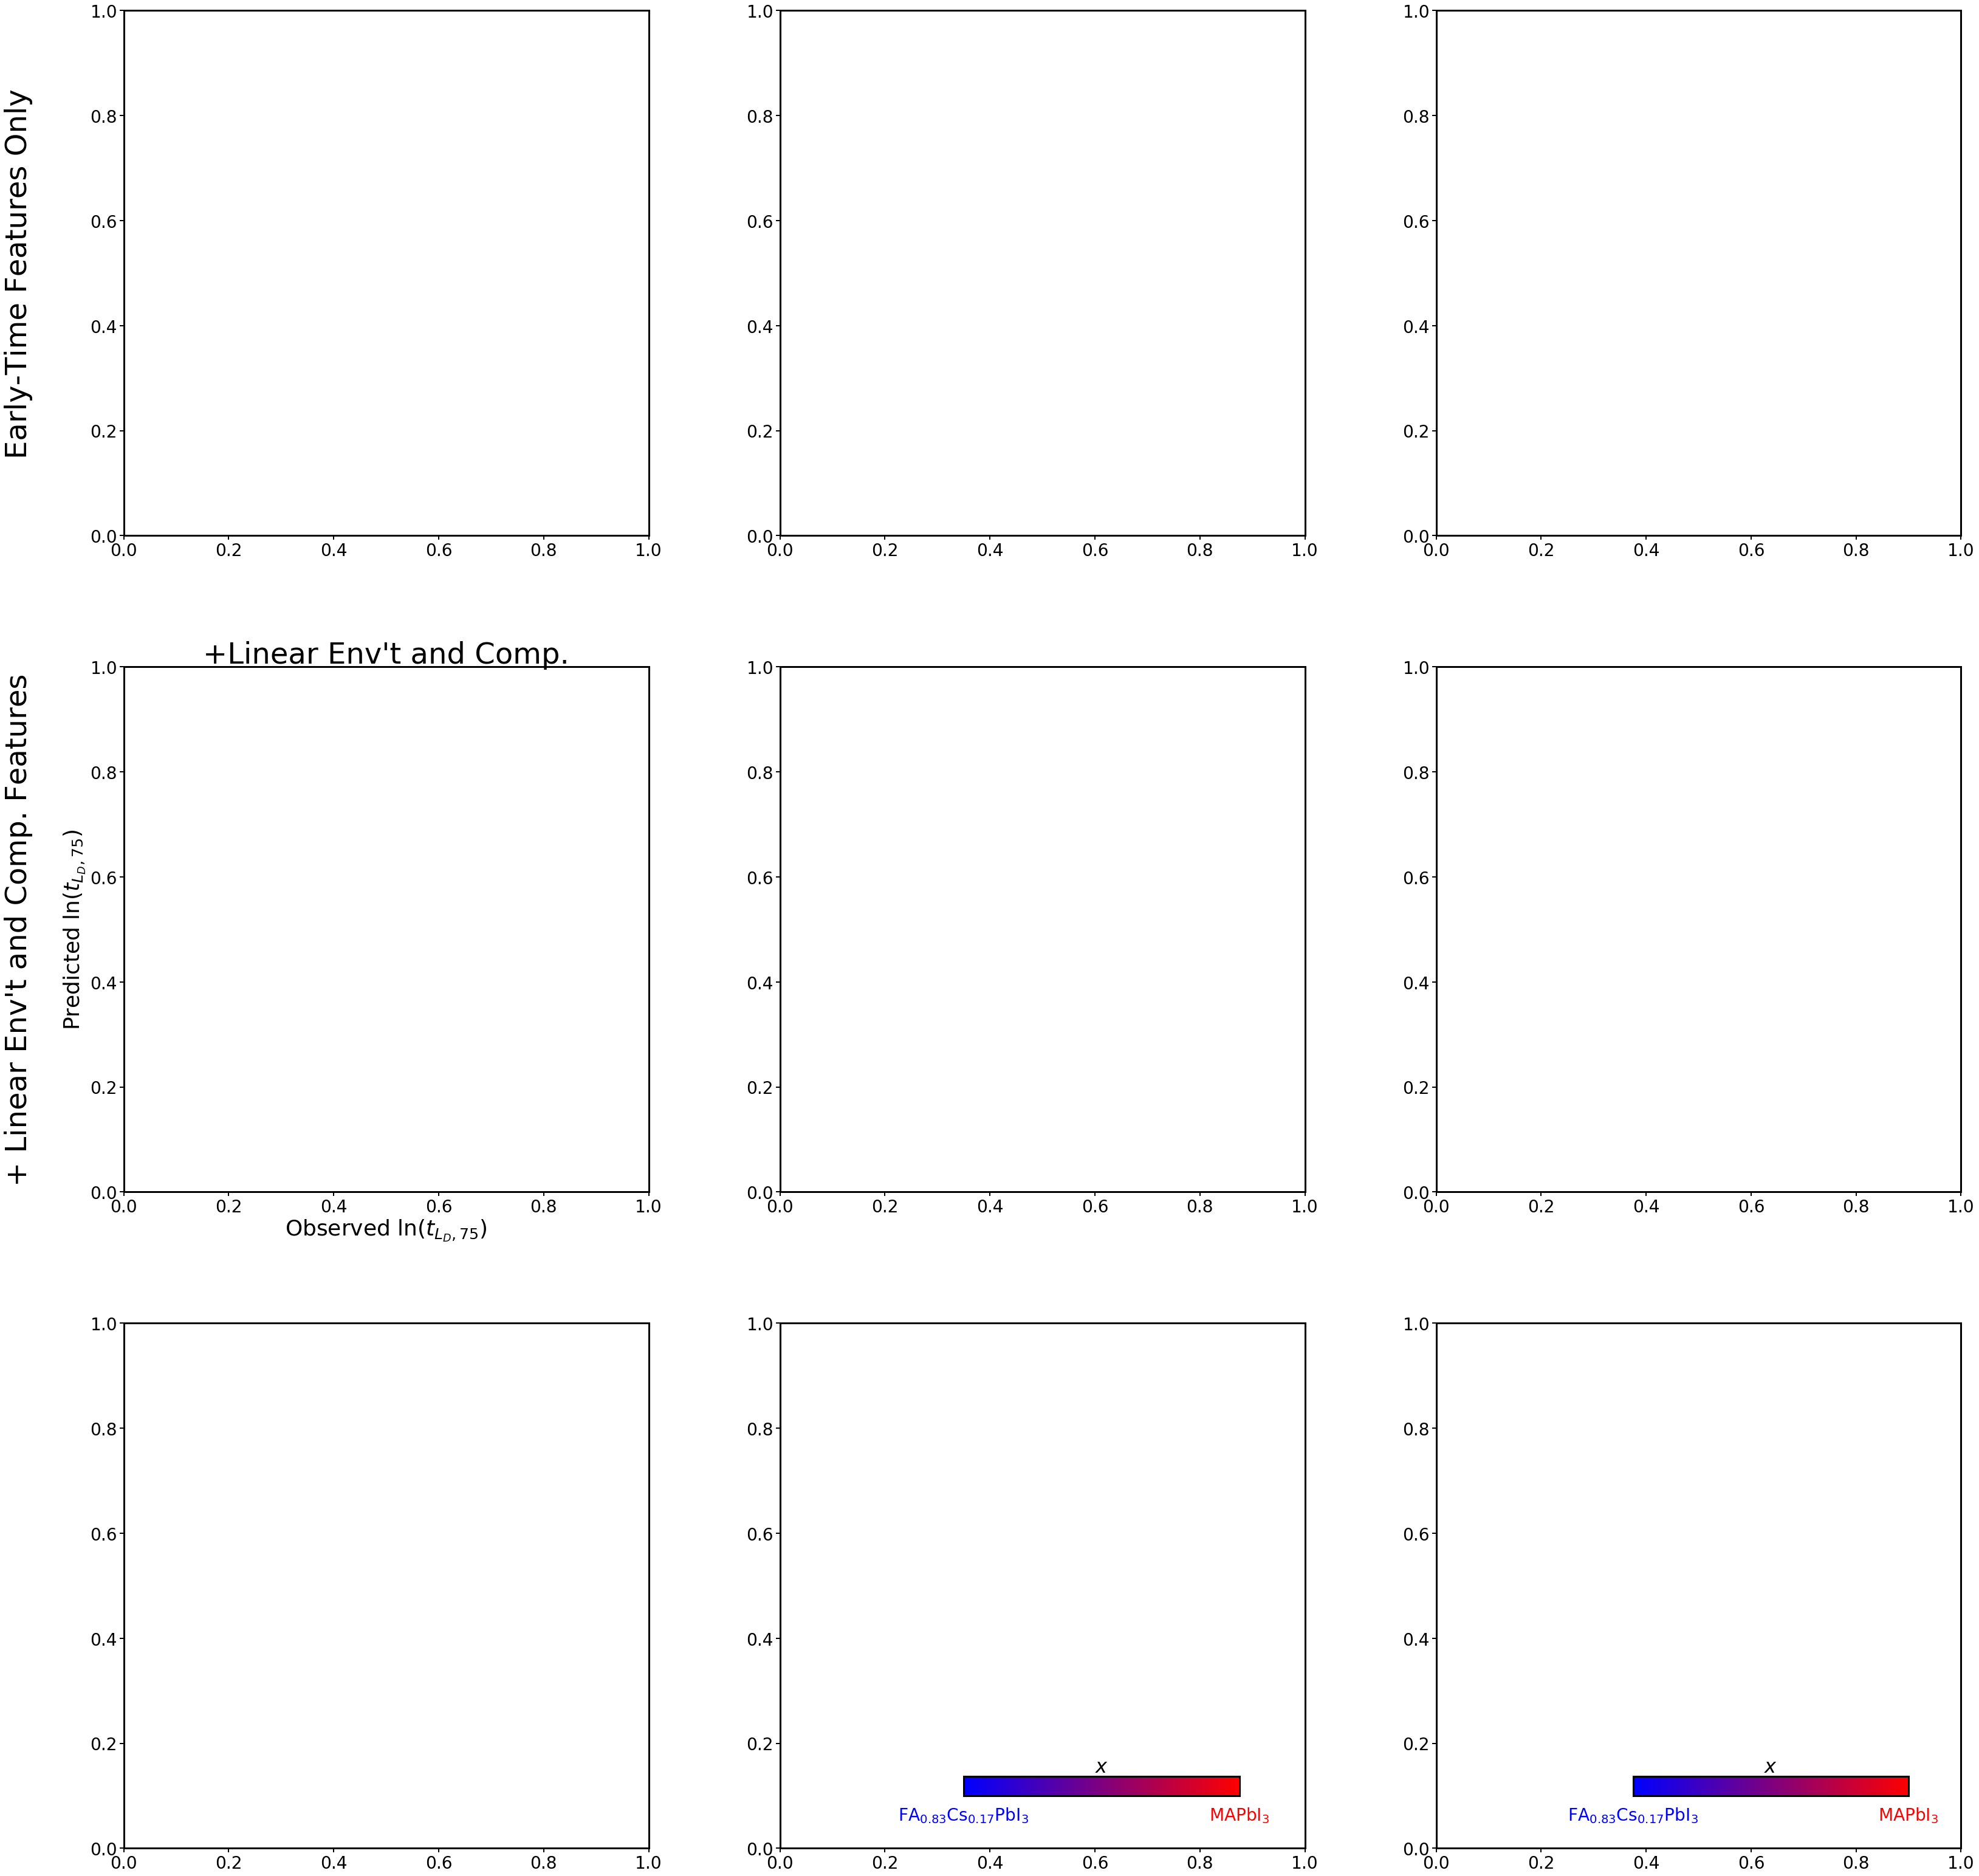

In [32]:
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_title('+Linear Env\'t and Comp.',fontsize=48)

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# 12. Adsorption Calculations 

Text(0.8, 2.2, 'Guo et al.')

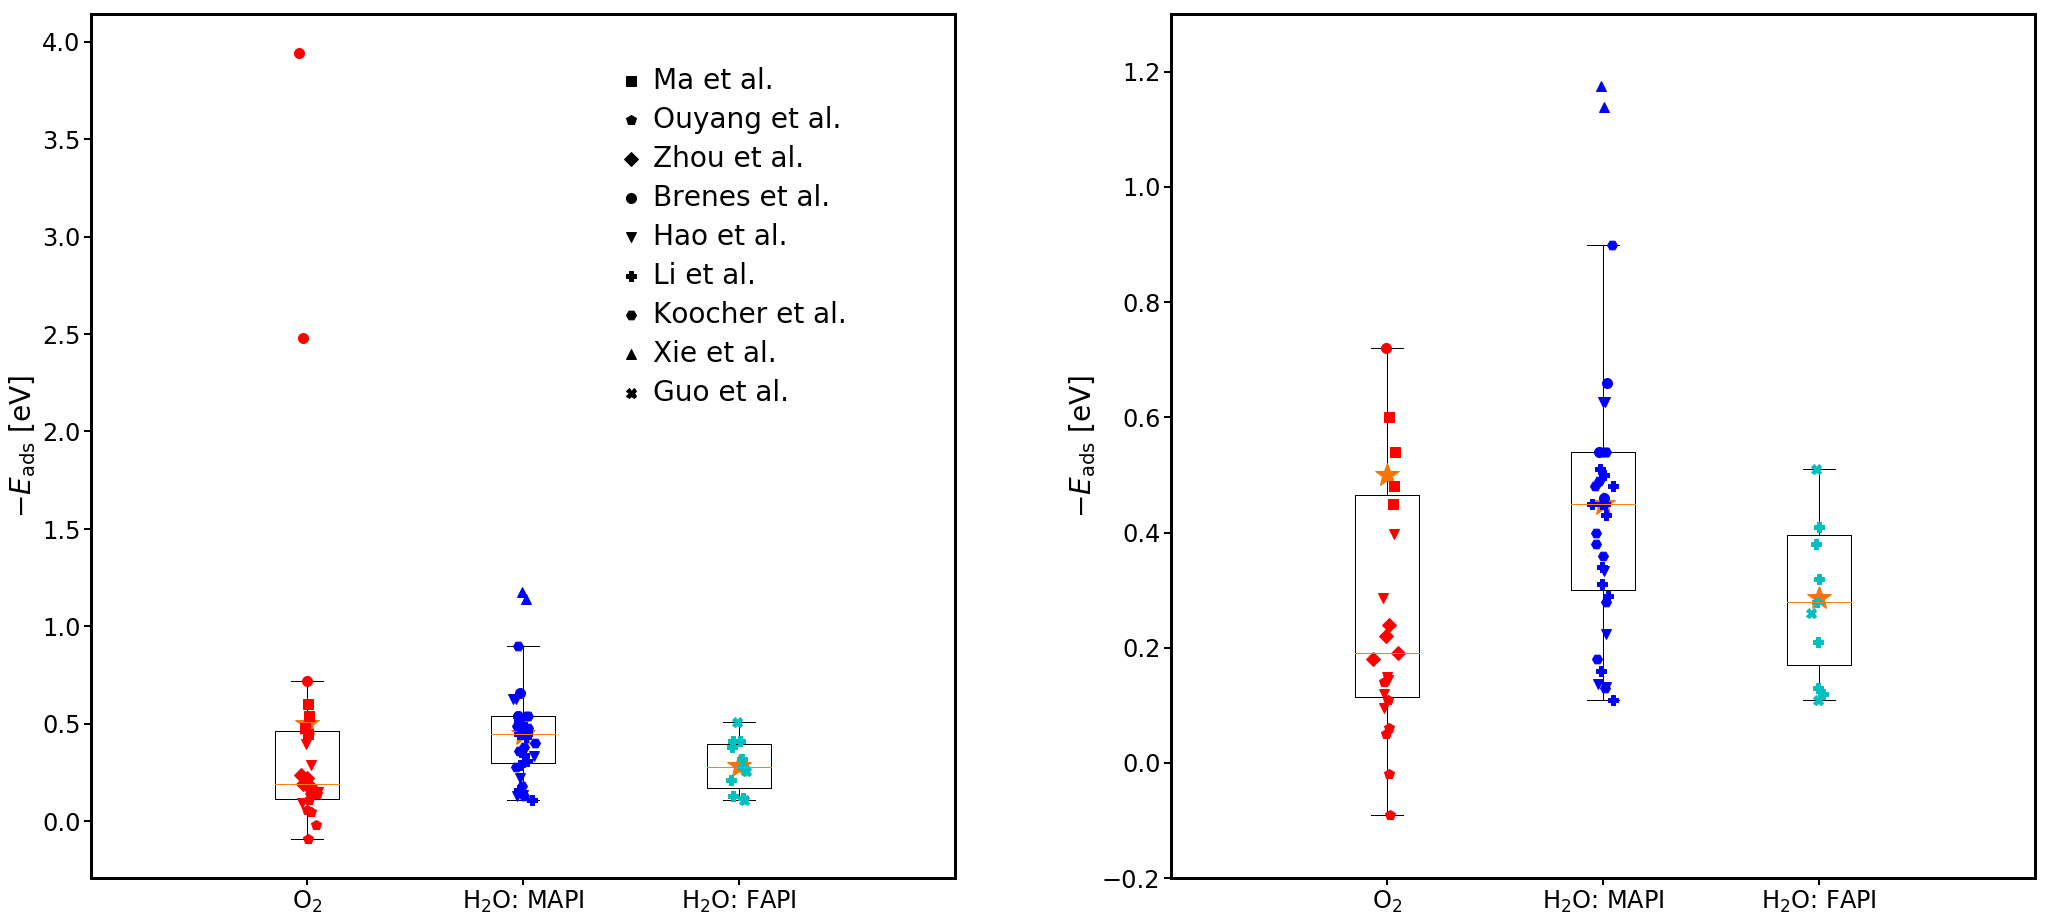

In [229]:
import random

O2_Ma = [-0.45,-0.48,-0.6,-0.54]
O2_Ouyang = [-0.14,-0.06,-0.11,-0.05,0.02,0.09]
O2_Zhou = [-0.19,-0.22,-0.24,-0.18]
O2_Brenes = [-3.94,-2.48,-0.72]
O2_Hao = [-0.398,-0.096,-0.12,-0.144,-0.15,-0.287]

O2_all = np.array(O2_Ma + O2_Ouyang + O2_Zhou + O2_Brenes + O2_Hao)

H2O_MAPI_Li = [-0.48,-0.34,-0.45,-0.45,-0.31,-0.45,-0.16,-0.11,-0.29,-0.51,-0.43,-0.5]
H2O_MAPI_Koocher = [-0.49,-0.36,-0.48,-0.4,-0.38,-0.9,-0.18,-0.13,-0.28,-0.54,-0.54,-0.54]
H2O_MAPI_Brenes = [-0.66,-0.46,-0.54]
H2O_MAPI_Hao = [-0.627,-0.627,-0.224,-0.137,-0.131,-0.333,]
H2O_MAPI_Xie = [-1.17594,-1.13924]

H2O_MAPI_all = np.array(H2O_MAPI_Li + H2O_MAPI_Koocher + H2O_MAPI_Brenes + H2O_MAPI_Hao + H2O_MAPI_Xie)

H2O_FAPI_Li = [-0.12,-0.21,-0.28,-0.32,-0.41,-0.38,-0.13,-0.41]
H2O_FAPI_Guo = [-0.26,-0.51,-0.11]

H2O_FAPI_all = np.array(H2O_FAPI_Li + H2O_FAPI_Guo)


# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 

ax[0][0].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])
ax[0][1].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])

def jittery_vector(length,noise_mean,noise_std):
    
    vector = np.zeros(length)
    for i in range(length):
        vector[i] += random.gauss(noise_mean,noise_std)
    
    return vector


ax[0][0].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][0].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][0].plot(1,np.mean(-H2O_FAPI_all),'c*',markersize=25,color='xkcd:orange')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][0].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][1].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][1].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][1].plot(1,np.mean(-H2O_FAPI_all),'*',markersize=25,color='xkcd:orange')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][1].set_ylim([-0.2,1.3])
ax[0][1].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][0].plot(0.75,3.8,color='k',marker='s',markersize=10)
ax[0][0].text(0.8,3.8,'Ma et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.6,color='k',marker='p',markersize=10)
ax[0][0].text(0.8,3.6,'Ouyang et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.4,color='k',marker='D',markersize=10)
ax[0][0].text(0.8,3.4,'Zhou et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.2,color='k',marker='o',markersize=10)
ax[0][0].text(0.8,3.2,'Brenes et al.',ha='left',va='center')
ax[0][0].plot(0.75,3,color='k',marker='v',markersize=10)
ax[0][0].text(0.8,3,'Hao et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.8,color='k',marker='P',markersize=10)
ax[0][0].text(0.8,2.8,'Li et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.6,color='k',marker='H',markersize=10)
ax[0][0].text(0.8,2.6,'Koocher et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.4,color='k',marker='^',markersize=10)
ax[0][0].text(0.8,2.4,'Xie et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.2,color='k',marker='X',markersize=10)
ax[0][0].text(0.8,2.2,'Guo et al.',ha='left',va='center')


In [212]:
np.median(H2O_FAPI_all)

-0.28

# Conformal Prediction

Use the Jackknife+ algorithm to establish confidence intervals and look at test reproducibility

## BEWARE: This block has to train 99 x 98 / 2 (= almost 5000) models, so it takes forever (~2 hours) to run. Use wisely.


In [24]:
##### Regenerate the dataset with all the features

# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
folds = len(Y)-1 # how many folds to do in k-fold cross-validation - 5 is standard


##### Start the Jackknife+ algorithm

# initialize matrices containing summary data
fij = np.zeros([n_trials,n_trials]) # prediction on sample i holding out samples i and j
fji = np.zeros([n_trials,n_trials]) # prediction on sample j holding out samples i and j
Rij = np.zeros([n_trials,n_trials]) # residual on sample i holding out samples i and j
Rji = np.zeros([n_trials,n_trials]) # residual on sample j holding out samples i and j


# Outer loop: iterate over samples in the test set
for j in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[j].copy()
    y_whold = Y.iloc[j:j+1].copy()
    X_train = X.drop(X.index[j]).copy()
    y_train = Y.drop(X.index[j]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # Inner loop: hold samples out one at a time from the training set
    for i in range(j):
        
        # keep track of things
        print('Holding out samples',(i,j))
        
        # partition training and test sets again
        X_val = X_train.iloc[i].copy()
        y_val = y_train.iloc[i:i+1].copy()
        X_val_train = X_train.drop(X_train.index[i]).copy()
        y_val_train = y_train.drop(X_train.index[i]).copy()

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_val_train,y_val_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        # mu_ij: model trained holding samples i and j out
        mu_ij = Lasso(alpha=alpha)
        mu_ij.fit(X_val_train,y_val_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=mu_ij.predict(np.array(X_val).reshape(1,-1))
        ytpred=mu_ij.predict(X_val_train)         
        
        # test predictions on held-out samples i and j
        fij[i,j] = mu_ij.predict(np.array(X_val).reshape(1,-1))
        fji[j,i] = mu_ij.predict(np.array(X_whold).reshape(1,-1))
        
        # calculate residuals on those predictions
        Rij[i,j] = np.abs(y_val - fij[i,j])
        Rji[j,i] = np.abs(y_whold - fji[j,i])



Number of Runs Total: 127
Number of Runs That Fail After Prediction Horizon: 100
Holding out samples (0, 1)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 2)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 2)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 3)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 3)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 3)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 4)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 4)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 4)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 4)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 5)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 5)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 5)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 5)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 5)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 6)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 6)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 6)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 6)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 6)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 6)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (6, 7)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 8)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 9)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (1, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (2, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (5, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (6, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (7, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (9, 10)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (1, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (2, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (3, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (5, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (6, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (7, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (9, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 11)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 12)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (10, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 13)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 14)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (2, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (6, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (7, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (8, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (13, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (14, 15)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (0, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 16)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (0, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 17)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 18)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (4, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (8, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (10, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (11, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (12, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (13, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 19)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 20)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 21)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 22)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 23)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (1, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (6, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (10, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (11, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (23, 24)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (20, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 25)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (13, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (22, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 26)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 27)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (11, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 28)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (11, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 29)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (11, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 30)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (2, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (9, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (13, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (21, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (22, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (24, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (28, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 31)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.001584893192461114}
Holding out samples (1, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (5, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (6, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (9, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (10, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.001584893192461114}
Holding out samples (11, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (13, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (17, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (19, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (24, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (26, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (27, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (28, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (30, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 32)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (0, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 33)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (13, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (18, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (22, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (24, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (28, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 34)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 35)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 36)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.001584893192461114}
Holding out samples (19, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (32, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 37)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 38)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (1, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (2, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (4, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (5, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (6, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (7, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (9, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (13, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (14, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (15, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (17, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (18, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (19, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (21, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (22, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (23, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (24, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (25, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (28, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (31, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (33, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (34, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (35, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (36, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (37, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (38, 39)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (0, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (1, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (2, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (3, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (5, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (6, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (7, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (9, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (13, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (17, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (18, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (19, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (21, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (22, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (24, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (28, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (29, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (30, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (31, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (34, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (35, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (36, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (38, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (39, 40)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (2, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (3, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (5, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (7, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (9, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (13, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (17, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (21, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (22, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (23, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (35, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (36, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (38, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (39, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 41)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (32, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 42)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 43)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (0, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (1, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (6, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (9, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 44)
{'alpha': 0.0025118864315095794}
Holding out samples (28, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (36, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (38, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 44)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (13, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (22, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (24, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (28, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (35, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (36, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (38, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (43, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (44, 45)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 46)
{'alpha': 0.0025118864315095794}
Holding out samples (7, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (44, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (45, 46)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 47)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (20, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (32, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (42, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (43, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (44, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (45, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (47, 48)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (32, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (44, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (45, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (47, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (48, 49)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (44, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (47, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (48, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 50)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 51)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (24, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (35, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (44, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (45, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (47, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (48, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (50, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (51, 52)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (9, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (32, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (42, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (44, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (45, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (47, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (48, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (50, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (51, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 53)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (25, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (44, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (47, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (48, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (50, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (51, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (53, 54)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (4, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (8, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (10, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (27, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (32, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (35, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (37, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (44, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (45, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (47, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (48, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (50, 55)
{'alpha': 0.0025118864315095794}
Holding out samples (51, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (53, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (54, 55)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (2, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (4, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (7, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (12, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (13, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (14, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (15, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (16, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (17, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (18, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (21, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (22, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (23, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (24, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (28, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (30, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (33, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (34, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (35, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (36, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (37, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (38, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (39, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (40, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (43, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (44, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (45, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (47, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (48, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (49, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (50, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (51, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (52, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (53, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (54, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (55, 56)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (1, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (2, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (5, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (6, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (7, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (8, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (9, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (11, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (13, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (14, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (15, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (16, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (17, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (18, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (19, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (21, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (22, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (23, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (24, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (25, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (27, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (28, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (30, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (32, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (34, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (35, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (36, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (37, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (38, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (39, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (41, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (42, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (44, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (45, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (46, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (47, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (48, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (49, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (50, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (51, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (53, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (54, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (55, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (56, 57)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (0, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (3, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (26, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (29, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (31, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (33, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (43, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (57, 58)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (20, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 59)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 60)
{'alpha': 0.06309573444801933}
Holding out samples (27, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 60)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 61)
{'alpha': 0.06309573444801933}
Holding out samples (49, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 61)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 62)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (12, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 63)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (12, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (60, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 64)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (1, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (4, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (8, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (12, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (17, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (19, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (21, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (22, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (24, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (27, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (31, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (32, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (34, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (35, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (37, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (40, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (49, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (50, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (51, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (54, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (56, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (61, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (64, 65)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (0, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 66)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 67)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (12, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 68)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 69)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 70)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 71)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (66, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 72)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 73)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 74)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 75)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 76)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 77)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 78)
{'alpha': 0.06309573444801933}
Holding out samples (55, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 78)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 79)
{'alpha': 0.06309573444801933}
Holding out samples (47, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 79)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 80)
{'alpha': 0.06309573444801933}
Holding out samples (51, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 80)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 81)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 82)
{'alpha': 0.06309573444801933}
Holding out samples (21, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (66, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 82)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (12, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 83)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 84)
{'alpha': 0.06309573444801933}
Holding out samples (2, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (12, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (35, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 84)
{'alpha': 0.06309573444801933}
Holding out samples (50, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 84)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (11, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (12, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (16, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (22, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (24, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (26, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (31, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (34, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (35, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (37, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (49, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (69, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 85)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (1, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (6, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (12, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (13, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (14, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (15, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (16, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (17, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (19, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (21, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (22, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (24, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (25, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (27, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (28, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (30, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (31, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (32, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (34, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (35, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (36, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (40, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (43, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (44, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.00630957344480193}
Holding out samples (49, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (51, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (56, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (73, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (76, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 86)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (0, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (12, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (16, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (22, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (32, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (35, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (40, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (49, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (76, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (86, 87)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (0, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (12, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 88)
{'alpha': 0.06309573444801933}
Holding out samples (69, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 88)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 89)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 90)
{'alpha': 0.06309573444801933}
Holding out samples (58, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 90)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 91)
{'alpha': 0.06309573444801933}
Holding out samples (16, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 91)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}
Holding out samples (20, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (91, 92)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (91, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (92, 93)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (66, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (91, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (92, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (93, 94)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (11, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (91, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (92, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (93, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (94, 95)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.00630957344480193}
Holding out samples (11, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.0025118864315095794}
Holding out samples (12, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (26, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (91, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (92, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (93, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (94, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (95, 96)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (0, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (1, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (2, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (3, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (4, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (5, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (6, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (7, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (8, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (9, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (10, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (11, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001584893192461114}
Holding out samples (12, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (13, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (14, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (15, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (16, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (17, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (18, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (19, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.025118864315095808}
Holding out samples (20, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (21, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (22, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (23, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (24, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (25, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003981071705534973}
Holding out samples (26, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (27, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (28, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (29, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (30, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (31, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (32, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (33, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (34, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (35, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (36, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (37, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (38, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (39, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (40, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (41, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (42, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (43, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (44, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (45, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (46, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (47, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (48, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (49, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (50, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (51, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (52, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (53, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (54, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (55, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (56, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (57, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (58, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (59, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (60, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (61, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (62, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (63, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (64, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (65, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (66, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (67, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (68, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (69, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (70, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (71, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (72, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (73, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (74, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (75, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (76, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (77, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (78, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (79, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (80, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (81, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (82, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (83, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (84, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (85, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (86, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (87, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (88, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (89, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (90, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (91, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (92, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (93, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (94, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (95, 97)


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.06309573444801933}
Holding out samples (96, 97)
{'alpha': 0.06309573444801933}


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# This Cell Is Not Strictly Necessary but could Save You a Lot of Time

In [27]:
np.savetxt(readpath + '201028_Jackknife_predictions.csv',F) 
np.savetxt(readpath + '201028_Jackknife_residuals.csv',R) 

In [43]:
alpha = 0.05 # parameter for determining quantiles for CI

# construct full residual and prediction matrices
F = fij + fji
R = Rij + Rji

# initialize lower and upper bounds bound of CI
L = np.zeros(n_trials)
U = np.zeros(n_trials)

uppers = F + R
lowers = F - R

medians = np.zeros(n_trials)
means = np.zeros(n_trials)
stds = np.zeros(n_trials)

# loop over all predictions
for i in range(n_trials):
    
    # get rid of the zeros on the diagonal
    up = list(uppers[i,:]) # upper CI bound
    up = up[:i] + up[i+1:]
    lo = list(lowers[i,:]) # lower CI bound
    lo = lo[:i] + lo[i+1:]
    f = list(F[i,:]) # predictions
    f = f[:i] + f[i+1:]
    
    # sort the upper and lower residual distributions 
    up.sort()
    lo.sort()
    
    # calculate the quantiles and add them to the arrays
    L[i] = np.quantile(lo,alpha)
    U[i] = np.quantile(up,1-alpha)
    
    #calculate stats
    medians[i] = np.median(f)
    means[i] = np.mean(f)
    stds[i] = np.std(f)
    


Text(0.5, 1.0, 'Jackknife+: 90% Prediction Intervals')

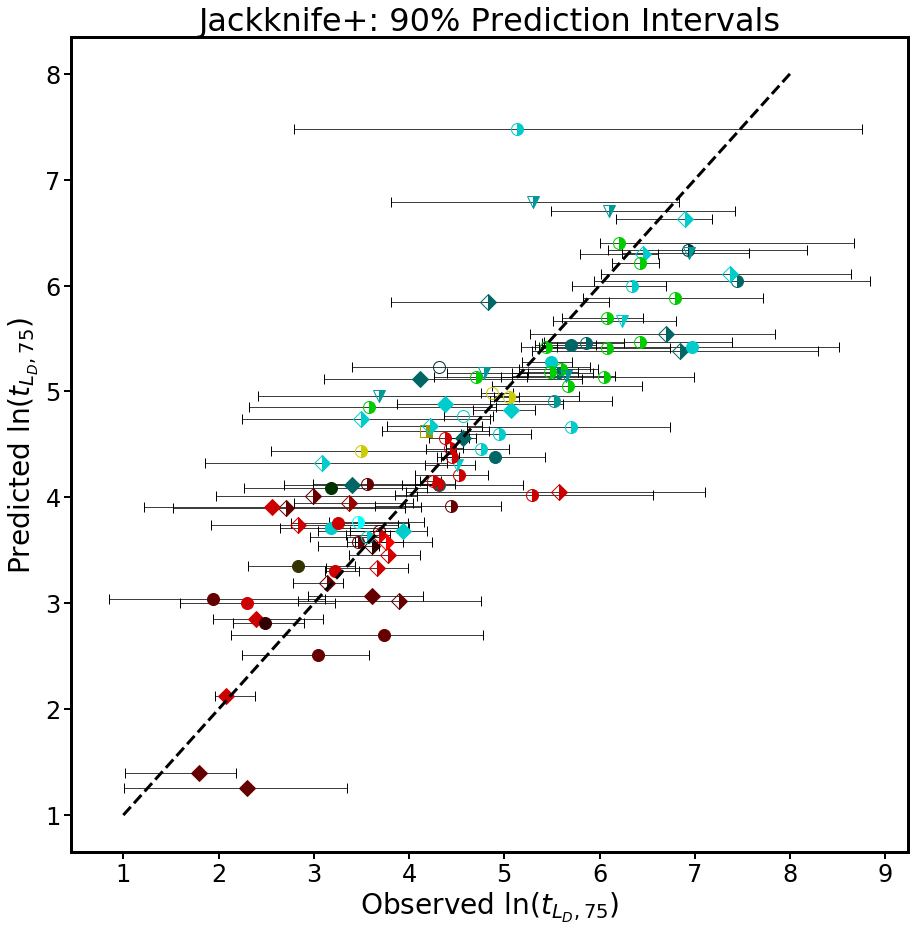

In [44]:
# make a parity plot with CIs

fig,ax = plt.subplots(figsize=(15,15))
ax.errorbar(Y,medians,xerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)
    
for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    
    ax.plot(Y.iloc[i],medians[i],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #ax.errorbar(Y.iloc[i],medians[i],xerr=np.array(asym_error),color=color,marker=marker,fillstyle=fill,linestyle=style)
    
    
x = np.linspace(1,8,num=2)
ax.plot(x,x,'k--')
ax.set_xlabel('Observed ln($t_{L_D,75}$)')
ax.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax.set_title('Jackknife+: 90% Prediction Intervals')



Text(0, 0.5, '$\\sigma$ [%]')

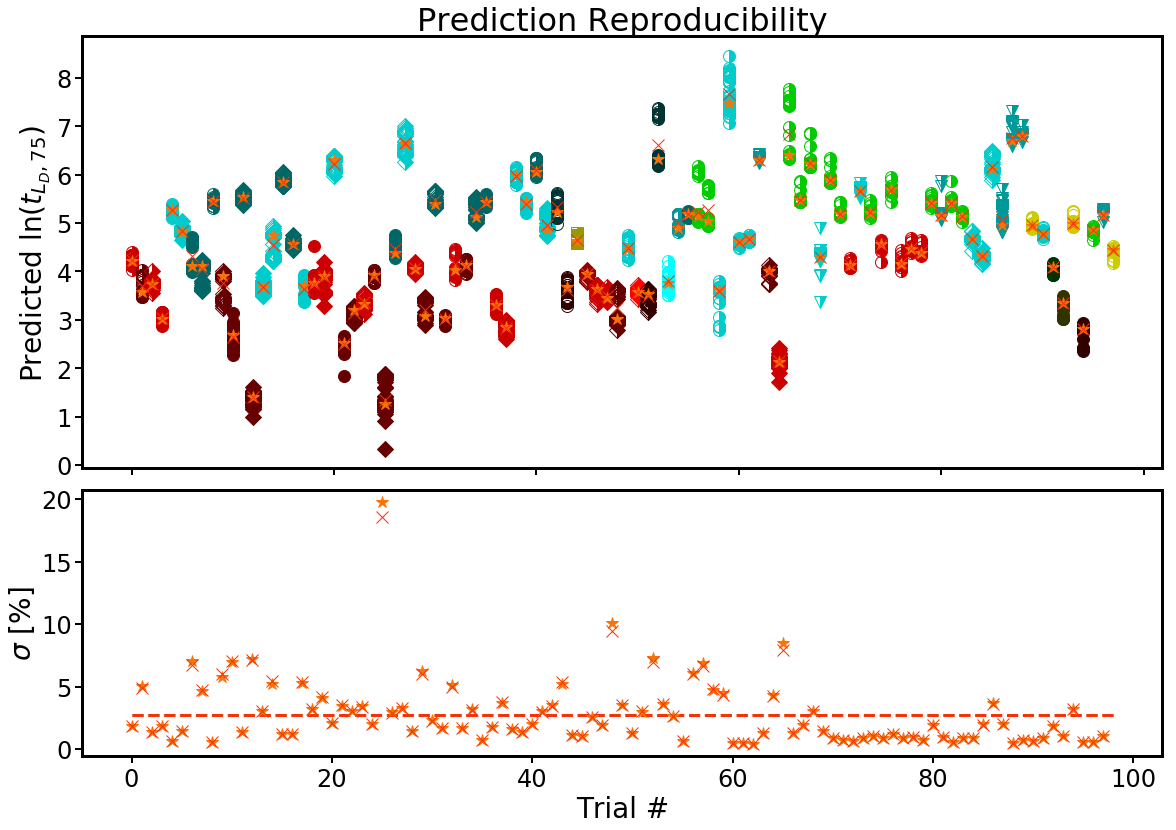

In [62]:
fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_axes([0,0.4,1,0.6])


for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    
    ax2.plot(np.ones(j)*i,list(F[i,:])[:i]+list(F[i,:])[i+1:],color=color,marker=marker,fillstyle=fill,linestyle=style)

ax2.plot(range(len(medians)),medians,marker='*',color='xkcd:orange',linestyle='')
ax2.plot(range(len(means)),means,marker='x',color='xkcd:vermillion',linestyle='')
    
ax2.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax2.set_title('Prediction Reproducibility')
ax2.set_xticklabels([])

ax3 = fig2.add_axes([0,0,1,0.37])
ax3.set_xlabel('Trial #')
ax3.plot(range(len(medians)),stds/medians*100,marker='*',color='xkcd:orange',linestyle='')
ax3.plot(range(len(means)),stds/means*100,marker='x',color='xkcd:vermillion',linestyle='')
ax3.hlines(np.mean(stds/medians*100),0,len(medians),color='xkcd:orange',linestyle='--')
ax3.hlines(np.mean(stds/means*100),0,len(means),color='xkcd:vermillion',linestyle='--')
ax3.set_ylabel('$\sigma$ [%]')